# Source of this Project:

https://arxiv.org/pdf/1505.00487.pdf

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import sys
#import ipdb
import time
import cv2
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
from tensorflow.contrib import rnn
#import fire
#from elapsedtimer import ElapsedTimer
from pathlib import Path
print('tensorflow version:',tf.__version__)

Using TensorFlow backend.


tensorflow version: 1.13.1


In [5]:
print(pd.__version__)

0.24.2


### Initializing the Input Parameters

In [6]:
text_path = r'C:\Project\video_corpus\video_corpus.csv'
feat_path = r'C:\Project\features'
path_prj = r'C:\Project'
feat_dir = 'features'
caption_file = 'video_corpus'

dim_image = 2048
dim_hidden = 512
batch_size = 8
lstm_steps = 80
video_lstm_step=80
caption_lstm_step=20 
mode = 'train'

if mode == 'train':
    train_text_path = text_path
    train_feat_path = feat_path
else:
    test_text_path = text_path
    test_feat_path = feat_path
learning_rate = 0.0001
epochs = 50
frame_step = 80 

model_path=path_prj

# Function to get the inputs of Pickle file of videos on CNN Layer Feature Output

In [7]:
def get_data(text_path,feat_path):
        text_data = pd.read_csv(text_path, sep=',')
        text_data = text_data[text_data['Language'] == 'English']
        text_data['video_path'] = text_data.apply(lambda row: row['VideoID']+'_'+str(int(row['Start']))+'_'+str(int(row['End']))+'.avi.npy', axis=1)
        text_data['video_path'] = text_data['video_path'].map(lambda x: os.path.join(feat_path, x))
        text_data = text_data[text_data['video_path'].map(lambda x: os.path.exists(x))]
        text_data = text_data[text_data['Description'].map(lambda x: isinstance(x, str))]
        
        unique_filenames = sorted(text_data['video_path'].unique())
        data = text_data[text_data['video_path'].map(lambda x: x in unique_filenames)]
        return data

# Test and Train Split

In [8]:
def train_test_split(data,test_frac=0.2):
        indices = np.arange(len(data))
        np.random.shuffle(indices)
        train_indices_rec = int((1 - test_frac)*len(data))
        indices_train = indices[:train_indices_rec]
        indices_test = indices[train_indices_rec:]
        data_train, data_test = data.iloc[indices_train],data.iloc[indices_test]
        print(data_train.head())
        print(data_test.head())
        data_train.reset_index(inplace=True)
        data_test.reset_index(inplace=True)
        return data_train,data_test


![LSTM](Capture1.jpg "LSTM Model")

Building Model consists of 2 LSTM models.

Each video Dimension is 80 * 4096 where as 80 frames are considered for each video.

<B/>Encoder</B>: 
LSTM1: Inputs each image frame and passes the Hidden units to LSTM2. LSTM2 process the output from LSTM1 and generates hidden units for the next processing

<B/>Decoder</B>:
LSTM1 is just rolled forward from where it left on Encoder and hidden units is passed to LSTM2. 
LSTM2 generates the next word caption, based on the Current word captioning along with the Hidden units from LSTM1.

LSTM2 word caption generation runs on propability function across each word to generate the Probability function which runs on SOFTMAX activity function.

Loss Function - Categorical cross entrophy

Optimizer - Adam


In [30]:
def build_model():
        # Defining the weights associated with the Network
        print (n_words)
        with tf.device('/cpu:0'): 
            word_emb = tf.Variable(tf.random_uniform([n_words, dim_hidden], -0.1, 0.1), name='word_emb')

        lstm1 = tf.nn.rnn_cell.BasicLSTMCell(dim_hidden, state_is_tuple=False)
        lstm2 = tf.nn.rnn_cell.BasicLSTMCell(dim_hidden, state_is_tuple=False)
        encode_W = tf.Variable( tf.random_uniform([dim_image,dim_hidden], -0.1, 0.1), name='encode_W')
        encode_b = tf.Variable( tf.zeros([dim_hidden]), name='encode_b')
        
        word_emb_W = tf.Variable(tf.random_uniform([dim_hidden,n_words], -0.1,0.1), name='word_emb_W')
        word_emb_b = tf.Variable(tf.zeros([n_words]), name='word_emb_b')
        
        # Placeholders 
        video = tf.placeholder(tf.float32, [batch_size, video_lstm_step, dim_image])
        video_mask = tf.placeholder(tf.float32, [batch_size, video_lstm_step])

        caption = tf.placeholder(tf.int32, [batch_size, caption_lstm_step+1])
        caption_mask = tf.placeholder(tf.float32, [batch_size, caption_lstm_step+1])

        video_flat = tf.reshape(video, [-1, dim_image])
        image_emb = tf.nn.xw_plus_b( video_flat, encode_W,encode_b )         
        image_emb = tf.reshape(image_emb, [batch_size, lstm_steps, dim_hidden])

        state1 = tf.zeros([batch_size, lstm1.state_size])
        state2 = tf.zeros([batch_size, lstm2.state_size])
        padding = tf.zeros([batch_size, dim_hidden])

        probs = []
        loss = 0.0

        #  Encoding Stage 
        for i in range(0, video_lstm_step):
            if i > 0:
                tf.get_variable_scope().reuse_variables()

            with tf.variable_scope("LSTM1"):
                output1, state1 = lstm1(image_emb[:,i,:], state1)

            with tf.variable_scope("LSTM2"):
                output2, state2 = lstm2(tf.concat([padding, output1],1), state2)

        #  Decoding Stage  to generate Captions 
        for i in range(0, caption_lstm_step):

            with tf.device("/cpu:0"):
                current_embed = tf.nn.embedding_lookup(word_emb, caption[:, i])

            tf.get_variable_scope().reuse_variables()

            with tf.variable_scope("LSTM1"):
                output1, state1 = lstm1(padding, state1)

            with tf.variable_scope("LSTM2"):
                output2, state2 = lstm2(tf.concat([current_embed, output1],1), state2)

            labels = tf.expand_dims(caption[:, i+1], 1)
            indices = tf.expand_dims(tf.range(0, batch_size, 1), 1)
            concated = tf.concat([indices, labels],1)
            onehot_labels = tf.sparse_to_dense(concated, tf.stack([batch_size, n_words]), 1.0, 0.0)

            logit_words = tf.nn.xw_plus_b(output2, word_emb_W, word_emb_b)
        # Computing the loss     
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logit_words,labels=onehot_labels)
            cross_entropy = cross_entropy * caption_mask[:,i]
            probs.append(logit_words)

            current_loss = tf.reduce_sum(cross_entropy)/batch_size
            loss = loss + current_loss
        with tf.variable_scope(tf.get_variable_scope(),reuse=tf.AUTO_REUSE):
            train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)    

        return loss, video, video_mask, caption, caption_mask, probs,train_op

Word Tokens are created, introduced 4 additional words. bos(begin of sentence) and eos(End of sentence) is very important as the LSTM2 is running on current and next word captoning, vectorizing the sentence with bos and eos will help in controlling any word loss. 

In [31]:
def create_word_dict(sentence_iterator, word_count_threshold=5):
        
        word_counts = {}
        sent_cnt = 0
        
        for sent in sentence_iterator:
            sent_cnt += 1
            for w in sent.lower().split(' '):
               word_counts[w] = word_counts.get(w, 0) + 1
        vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
        
        idx2word = {}
        idx2word[0] = '<pad>'
        idx2word[1] = '<bos>'
        idx2word[2] = '<eos>'
        idx2word[3] = '<unk>'
    
        word2idx = {}
        word2idx['<pad>'] = 0
        word2idx['<bos>'] = 1
        word2idx['<eos>'] = 2
        word2idx['<unk>'] = 3
    
        for idx, w in enumerate(vocab):
            word2idx[w] = idx+4
            idx2word[idx+4] = w
    
        word_counts['<pad>'] = sent_cnt
        word_counts['<bos>'] = sent_cnt
        word_counts['<eos>'] = sent_cnt
        word_counts['<unk>'] = sent_cnt
    
        return word2idx,idx2word

In [10]:
text_path

'C:\\Project\\video_corpus\\video_corpus.csv'

In [11]:
data = get_data(text_path,feat_path)

In [120]:
data

,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description,video_path
18,mv89psg6zh4,33,46,682611,clean,66,English,A bird in a sink keeps getting under the runni...,C:\Project\features\mv89psg6zh4_33_46.avi.npy
19,mv89psg6zh4,33,46,760882,clean,16,English,A bird is bathing in a sink.,C:\Project\features\mv89psg6zh4_33_46.avi.npy
20,mv89psg6zh4,33,46,878566,clean,76,English,A bird is splashing around under a running fau...,C:\Project\features\mv89psg6zh4_33_46.avi.npy
21,mv89psg6zh4,33,46,707318,clean,14,English,A bird is bathing in a sink.,C:\Project\features\mv89psg6zh4_33_46.avi.npy
22,mv89psg6zh4,33,46,135621,clean,58,English,A bird is standing in a sink drinking water th...,C:\Project\features\mv89psg6zh4_33_46.avi.npy
23,mv89psg6zh4,33,46,257511,clean,57,English,A faucet is running while a bird stands in the...,C:\Project\features\mv89psg6zh4_33_46.avi.npy
24,mv89psg6zh4,33,46,435773,clean,25,English,A bird is playing in a sink with running water.,C:\Project\features\mv89psg6zh4_33_46.avi.npy
25,mv89psg6zh4,33,46,275759,clean,27,English,A bird is playing in tap water.,C:\Project\features\mv89psg6zh4_33_46.avi.npy
26,mv89psg6zh4,33,46,157374,clean,30,English,A bird is bathing in the sink.,C:\Project\features\mv89psg6zh4_33_46.avi.npy
27,mv89psg6zh4,33,46,373663,clean,36,English,A bird is taking a bath.,C:\Project\features\mv89psg6zh4_33_46.avi.npy


In [15]:
train_data,test_data = train_test_split(data,test_frac=0.2)

           VideoID  Start  End  WorkerID      Source  AnnotationTime Language  \
18774  WTf5EgVY5uU     66   75    844963  unverified             266  English   
46937  XOAgUVVwKEA      8   20    297776       clean              41  English   
28788  bkazguPsusc     74   85    418656  unverified              60  English   
92206  RZL9irxnhZ0     34   40    252681       clean              29  English   
30734  2YhDTpzxd3c    115  120    807872       clean              20  English   

                                             Description  \
18774     A woman is chopping a garlic into tiny pieces.   
46937              A baby eats spaghetti with her hands.   
28788                     A cat is playing under a sofa.   
92206  A man is giving an interview in front of a lot...   
30734                   A car runs over a person's hand.   

                                            video_path  
18774    C:\Project\features\WTf5EgVY5uU_66_75.avi.npy  
46937     C:\Project\features\XOAgUVVw

In [32]:
train_data.to_csv(f'{path_prj}/train.csv',index=False)
test_data.to_csv(f'{path_prj}/test.csv',index=False)

print(f'Processed train file written to {path_prj}/train_corpus.csv')
print(f'Processed test file written to {path_prj}/test_corpus.csv')

Processed train file written to C:\Project/train_corpus.csv
Processed test file written to C:\Project/test_corpus.csv


In [33]:
train_captions = train_data['Description'].values
test_captions = test_data['Description'].values
captions_list = list(train_captions) 
captions = np.asarray(captions_list, dtype=np.object)

captions = list(map(lambda x: x.replace('.', ''), captions))
captions = list(map(lambda x: x.replace(',', ''), captions))
captions = list(map(lambda x: x.replace('"', ''), captions))
captions = list(map(lambda x: x.replace('\n', ''), captions))
captions = list(map(lambda x: x.replace('?', ''), captions))
captions = list(map(lambda x: x.replace('!', ''), captions))
captions = list(map(lambda x: x.replace('\\', ''), captions))
captions = list(map(lambda x: x.replace('/', ''), captions))

In [34]:
word2idx,idx2word = create_word_dict(captions, word_count_threshold=0)

In [35]:
np.save(path_prj+ "\\word2idx",word2idx)
np.save(path_prj+ "\\idx2word" ,idx2word)
n_words = len(word2idx)
n_words

11754

In [36]:
for state in word2idx:
    word2idx.pop(state)
    break
len(word2idx)

11753

In [37]:
tf_loss, tf_video,tf_video_mask,tf_caption,tf_caption_mask, tf_probs,train_op= build_model()

11754
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.cast instead.


In [20]:
sess = tf.InteractiveSession()

saver = tf.train.Saver(max_to_keep=100, write_version=1)
tf.global_variables_initializer().run()

In [21]:
loss_out = open('loss.txt', 'w')
val_loss = []

In [22]:
current_train_data = train_data.groupby(['video_path']).first().reset_index()

In [23]:
current_train_data [current_train_data['VideoID']=='-AwoiGR6c8M']

,video_path,index,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description
5,C:\Project\features\-AwoiGR6c8M_10_14.avi.npy,43978,-AwoiGR6c8M,10,14,922727,clean,29,English,A boy is playing a piano.


In [24]:
train_data [train_data['VideoID']=='-AwoiGR6c8M'].sort_index()

,index,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description,video_path
1668,43978,-AwoiGR6c8M,10,14,922727,clean,29,English,A boy is playing a piano.,C:\Project\features\-AwoiGR6c8M_10_14.avi.npy
2350,44006,-AwoiGR6c8M,10,14,741585,unverified,14,English,A kid is playing a piano.,C:\Project\features\-AwoiGR6c8M_10_14.avi.npy
3569,43986,-AwoiGR6c8M,10,14,215924,clean,35,English,A boy plays the piano.,C:\Project\features\-AwoiGR6c8M_10_14.avi.npy
3572,43993,-AwoiGR6c8M,10,14,762891,clean,13,English,The boy is playing the piano.,C:\Project\features\-AwoiGR6c8M_10_14.avi.npy
3832,44005,-AwoiGR6c8M,10,14,464046,unverified,706,English,The song dance very enjoy,C:\Project\features\-AwoiGR6c8M_10_14.avi.npy
4736,43981,-AwoiGR6c8M,10,14,617730,clean,17,English,A boy is playing the piano.,C:\Project\features\-AwoiGR6c8M_10_14.avi.npy
8379,43982,-AwoiGR6c8M,10,14,435773,clean,17,English,A boy is playing the piano.,C:\Project\features\-AwoiGR6c8M_10_14.avi.npy
9408,43977,-AwoiGR6c8M,10,14,760882,clean,21,English,A boy is playing a piano.,C:\Project\features\-AwoiGR6c8M_10_14.avi.npy
11832,43979,-AwoiGR6c8M,10,14,155632,clean,18,English,A boy is playing piano.,C:\Project\features\-AwoiGR6c8M_10_14.avi.npy
14775,43992,-AwoiGR6c8M,10,14,257003,clean,62,English,A youngster is sitting on a piano.,C:\Project\features\-AwoiGR6c8M_10_14.avi.npy


In [25]:
train_data.shape

(61241, 10)

# An Epoch of 50 has been trained on the data. It took around 15 hours to complete. When ran on less then 10 epochs the video captioning generated is bad

Batch starting index:  0  Epoch:  0  loss:  103.0838  Elapsed time:  45.369425535202026
Batch starting index:  8  Epoch:  0  loss:  99.85904  Elapsed time:  2.419175863265991
Batch starting index:  16  Epoch:  0  loss:  88.67008  Elapsed time:  2.2181901931762695
Batch starting index:  24  Epoch:  0  loss:  80.064995  Elapsed time:  2.078206777572632
Batch starting index:  32  Epoch:  0  loss:  78.46932  Elapsed time:  2.031341075897217
Batch starting index:  40  Epoch:  0  loss:  89.54514  Elapsed time:  2.015507698059082
Batch starting index:  48  Epoch:  0  loss:  76.36182  Elapsed time:  2.156329393386841
Batch starting index:  56  Epoch:  0  loss:  74.67275  Elapsed time:  2.125087022781372
Batch starting index:  64  Epoch:  0  loss:  102.735794  Elapsed time:  2.046950578689575
Batch starting index:  72  Epoch:  0  loss:  99.30897  Elapsed time:  2.0469725131988525
Batch starting index:  80  Epoch:  0  loss:  77.59437  Elapsed time:  1.9688067436218262
Batch starting index:  88  

Batch starting index:  728  Epoch:  0  loss:  45.486996  Elapsed time:  1.968825101852417
Batch starting index:  736  Epoch:  0  loss:  52.004845  Elapsed time:  1.9532067775726318
Batch starting index:  744  Epoch:  0  loss:  50.161026  Elapsed time:  1.9375712871551514
Batch starting index:  752  Epoch:  0  loss:  48.836132  Elapsed time:  2.218841791152954
Batch starting index:  760  Epoch:  0  loss:  39.046368  Elapsed time:  2.0000813007354736
Batch starting index:  768  Epoch:  0  loss:  45.110027  Elapsed time:  1.9375736713409424
Batch starting index:  776  Epoch:  0  loss:  52.30596  Elapsed time:  1.9375836849212646
Batch starting index:  784  Epoch:  0  loss:  44.536774  Elapsed time:  1.9063284397125244
Batch starting index:  792  Epoch:  0  loss:  43.051437  Elapsed time:  1.921950340270996
Batch starting index:  800  Epoch:  0  loss:  43.135178  Elapsed time:  1.9063279628753662
Batch starting index:  808  Epoch:  0  loss:  43.274143  Elapsed time:  1.8906962871551514
Bat

Batch starting index:  1456  Epoch:  0  loss:  45.193798  Elapsed time:  2.1094651222229004
Batch starting index:  1464  Epoch:  0  loss:  29.691923  Elapsed time:  2.0157058238983154
Batch starting index:  1472  Epoch:  0  loss:  39.96596  Elapsed time:  2.000079870223999
Batch starting index:  1480  Epoch:  0  loss:  37.016262  Elapsed time:  2.0317020416259766
Batch starting index:  1488  Epoch:  0  loss:  33.845642  Elapsed time:  1.9061386585235596
Batch starting index:  1496  Epoch:  0  loss:  41.696953  Elapsed time:  1.9842677116394043
Batch starting index:  1504  Epoch:  0  loss:  45.734653  Elapsed time:  1.9688301086425781
Batch starting index:  1512  Epoch:  0  loss:  31.334816  Elapsed time:  2.0782113075256348
Batch starting index:  1520  Epoch:  0  loss:  55.244595  Elapsed time:  2.109452486038208
Batch starting index:  1528  Epoch:  0  loss:  57.47331  Elapsed time:  1.9532015323638916
Batch starting index:  1536  Epoch:  0  loss:  38.84035  Elapsed time:  1.9219951629

Batch starting index:  280  Epoch:  1  loss:  36.707096  Elapsed time:  1.8438262939453125
Batch starting index:  288  Epoch:  1  loss:  37.054615  Elapsed time:  1.9063327312469482
Batch starting index:  296  Epoch:  1  loss:  33.03111  Elapsed time:  2.1094627380371094
Batch starting index:  304  Epoch:  1  loss:  52.29929  Elapsed time:  1.9220104217529297
Batch starting index:  312  Epoch:  1  loss:  42.252384  Elapsed time:  1.9532244205474854
Batch starting index:  320  Epoch:  1  loss:  39.713085  Elapsed time:  1.906294345855713
Batch starting index:  328  Epoch:  1  loss:  32.263058  Elapsed time:  1.8594520092010498
Batch starting index:  336  Epoch:  1  loss:  39.38224  Elapsed time:  1.8751215934753418
Batch starting index:  344  Epoch:  1  loss:  36.366333  Elapsed time:  1.8751466274261475
Batch starting index:  352  Epoch:  1  loss:  35.799213  Elapsed time:  1.8751556873321533
Batch starting index:  360  Epoch:  1  loss:  36.758896  Elapsed time:  2.01548433303833
Batch

Batch starting index:  1008  Epoch:  1  loss:  32.44927  Elapsed time:  1.8751304149627686
Batch starting index:  1016  Epoch:  1  loss:  36.1904  Elapsed time:  1.8125321865081787
Batch starting index:  1024  Epoch:  1  loss:  41.57042  Elapsed time:  1.9219396114349365
Batch starting index:  1032  Epoch:  1  loss:  34.802692  Elapsed time:  1.9844515323638916
Batch starting index:  1040  Epoch:  1  loss:  35.54827  Elapsed time:  2.015714406967163
Batch starting index:  1048  Epoch:  1  loss:  29.544762  Elapsed time:  1.9375696182250977
Batch starting index:  1056  Epoch:  1  loss:  36.477097  Elapsed time:  1.8594539165496826
Batch starting index:  1064  Epoch:  1  loss:  35.574413  Elapsed time:  1.8594489097595215
Batch starting index:  1072  Epoch:  1  loss:  46.424404  Elapsed time:  1.8438265323638916
Batch starting index:  1080  Epoch:  1  loss:  41.753555  Elapsed time:  1.8438284397125244
Batch starting index:  1088  Epoch:  1  loss:  45.108032  Elapsed time:  1.87507987022

Batch starting index:  1728  Epoch:  1  loss:  35.49382  Elapsed time:  1.8594510555267334
Batch starting index:  1736  Epoch:  1  loss:  36.337936  Elapsed time:  1.8594560623168945
Batch starting index:  1744  Epoch:  1  loss:  43.281456  Elapsed time:  1.8438568115234375
Batch starting index:  1752  Epoch:  1  loss:  64.68692  Elapsed time:  1.8437848091125488
Batch starting index:  1760  Epoch:  1  loss:  36.681232  Elapsed time:  1.812570571899414
Batch starting index:  1768  Epoch:  1  loss:  32.176254  Elapsed time:  1.8448219299316406
Batch starting index:  1776  Epoch:  1  loss:  30.595085  Elapsed time:  1.9834587574005127
Batch starting index:  1784  Epoch:  1  loss:  33.704346  Elapsed time:  2.015753984451294
Batch starting index:  1792  Epoch:  1  loss:  27.568718  Elapsed time:  1.843785047531128
Batch starting index:  1800  Epoch:  1  loss:  41.23914  Elapsed time:  1.859445571899414
Batch starting index:  1808  Epoch:  1  loss:  35.167816  Elapsed time:  1.843822956085

Batch starting index:  592  Epoch:  2  loss:  36.96047  Elapsed time:  2.0469613075256348
Batch starting index:  600  Epoch:  2  loss:  34.42752  Elapsed time:  1.8594443798065186
Batch starting index:  608  Epoch:  2  loss:  40.08124  Elapsed time:  1.8750755786895752
Batch starting index:  616  Epoch:  2  loss:  40.528297  Elapsed time:  1.8907036781311035
Batch starting index:  624  Epoch:  2  loss:  32.468853  Elapsed time:  1.8594558238983154
Batch starting index:  632  Epoch:  2  loss:  42.73129  Elapsed time:  1.8438191413879395
Batch starting index:  640  Epoch:  2  loss:  44.936253  Elapsed time:  1.8282051086425781
Batch starting index:  648  Epoch:  2  loss:  53.32609  Elapsed time:  1.8594460487365723
Batch starting index:  656  Epoch:  2  loss:  38.476715  Elapsed time:  2.156339406967163
Batch starting index:  664  Epoch:  2  loss:  44.172245  Elapsed time:  1.8906991481781006
Batch starting index:  672  Epoch:  2  loss:  40.18182  Elapsed time:  1.875077247619629
Batch s

Batch starting index:  1320  Epoch:  2  loss:  52.5806  Elapsed time:  1.828200101852417
Batch starting index:  1328  Epoch:  2  loss:  32.0446  Elapsed time:  1.8438267707824707
Batch starting index:  1336  Epoch:  2  loss:  28.620396  Elapsed time:  2.109485149383545
Batch starting index:  1344  Epoch:  2  loss:  35.77705  Elapsed time:  1.8594515323638916
Batch starting index:  1352  Epoch:  2  loss:  39.136555  Elapsed time:  1.8282020092010498
Batch starting index:  1360  Epoch:  2  loss:  32.930344  Elapsed time:  1.8281981945037842
Batch starting index:  1368  Epoch:  2  loss:  27.423529  Elapsed time:  1.8440704345703125
Batch starting index:  1376  Epoch:  2  loss:  30.608232  Elapsed time:  1.7967042922973633
Batch starting index:  1384  Epoch:  2  loss:  40.051064  Elapsed time:  1.8601977825164795
Batch starting index:  1392  Epoch:  2  loss:  43.08378  Elapsed time:  1.8430955410003662
Batch starting index:  1400  Epoch:  2  loss:  45.98496  Elapsed time:  1.95318841934204

Batch starting index:  184  Epoch:  3  loss:  32.776237  Elapsed time:  1.843834638595581
Batch starting index:  192  Epoch:  3  loss:  33.087715  Elapsed time:  1.9218330383300781
Batch starting index:  200  Epoch:  3  loss:  25.30688  Elapsed time:  1.8281586170196533
Batch starting index:  208  Epoch:  3  loss:  39.477943  Elapsed time:  1.890700101852417
Batch starting index:  216  Epoch:  3  loss:  45.680637  Elapsed time:  2.156339168548584
Batch starting index:  224  Epoch:  3  loss:  47.359013  Elapsed time:  1.859449863433838
Batch starting index:  232  Epoch:  3  loss:  39.443184  Elapsed time:  1.8438262939453125
Batch starting index:  240  Epoch:  3  loss:  41.856316  Elapsed time:  1.906327247619629
Batch starting index:  248  Epoch:  3  loss:  49.511143  Elapsed time:  1.8750803470611572
Batch starting index:  256  Epoch:  3  loss:  32.4555  Elapsed time:  1.828195571899414
Batch starting index:  264  Epoch:  3  loss:  37.96882  Elapsed time:  1.859450340270996
Batch star

Batch starting index:  912  Epoch:  3  loss:  27.878778  Elapsed time:  1.813725233078003
Batch starting index:  920  Epoch:  3  loss:  34.85252  Elapsed time:  1.8748359680175781
Batch starting index:  928  Epoch:  3  loss:  39.614265  Elapsed time:  1.8594474792480469
Batch starting index:  936  Epoch:  3  loss:  35.10923  Elapsed time:  1.843824863433838
Batch starting index:  944  Epoch:  3  loss:  41.872772  Elapsed time:  1.859449863433838
Batch starting index:  952  Epoch:  3  loss:  34.626335  Elapsed time:  1.9375827312469482
Batch starting index:  960  Epoch:  3  loss:  37.283054  Elapsed time:  2.1094577312469482
Batch starting index:  968  Epoch:  3  loss:  38.009876  Elapsed time:  1.84383225440979
Batch starting index:  976  Epoch:  3  loss:  50.174667  Elapsed time:  1.8438184261322021
Batch starting index:  984  Epoch:  3  loss:  40.191525  Elapsed time:  1.8438332080841064
Batch starting index:  992  Epoch:  3  loss:  26.836107  Elapsed time:  1.8125700950622559
Batch 

Batch starting index:  1632  Epoch:  3  loss:  38.362183  Elapsed time:  2.125092029571533
Batch starting index:  1640  Epoch:  3  loss:  45.19085  Elapsed time:  2.0000767707824707
Batch starting index:  1648  Epoch:  3  loss:  38.282593  Elapsed time:  1.8907454013824463
Batch starting index:  1656  Epoch:  3  loss:  45.903805  Elapsed time:  1.8750576972961426
Batch starting index:  1664  Epoch:  3  loss:  38.14505  Elapsed time:  1.8282084465026855
Batch starting index:  1672  Epoch:  3  loss:  37.47423  Elapsed time:  1.8438165187835693
Batch starting index:  1680  Epoch:  3  loss:  39.75215  Elapsed time:  1.8750786781311035
Batch starting index:  1688  Epoch:  3  loss:  41.636208  Elapsed time:  1.8125724792480469
Batch starting index:  1696  Epoch:  3  loss:  39.62536  Elapsed time:  1.96883225440979
Batch starting index:  1704  Epoch:  3  loss:  36.289745  Elapsed time:  2.0469624996185303
Batch starting index:  1712  Epoch:  3  loss:  37.51786  Elapsed time:  1.81258845329284

Batch starting index:  496  Epoch:  4  loss:  41.61141  Elapsed time:  1.8438260555267334
Batch starting index:  504  Epoch:  4  loss:  28.096169  Elapsed time:  1.8282005786895752
Batch starting index:  512  Epoch:  4  loss:  32.63048  Elapsed time:  2.203217029571533
Batch starting index:  520  Epoch:  4  loss:  34.653843  Elapsed time:  1.8438310623168945
Batch starting index:  528  Epoch:  4  loss:  23.396267  Elapsed time:  1.8282051086425781
Batch starting index:  536  Epoch:  4  loss:  32.00664  Elapsed time:  1.9063167572021484
Batch starting index:  544  Epoch:  4  loss:  27.264147  Elapsed time:  1.8438363075256348
Batch starting index:  552  Epoch:  4  loss:  40.53737  Elapsed time:  1.8594393730163574
Batch starting index:  560  Epoch:  4  loss:  48.816868  Elapsed time:  1.8438422679901123
Batch starting index:  568  Epoch:  4  loss:  60.613922  Elapsed time:  1.843829870223999
Batch starting index:  576  Epoch:  4  loss:  41.71257  Elapsed time:  2.015730381011963
Batch s

Batch starting index:  1224  Epoch:  4  loss:  37.6014  Elapsed time:  1.8279857635498047
Batch starting index:  1232  Epoch:  4  loss:  21.744553  Elapsed time:  1.8750853538513184
Batch starting index:  1240  Epoch:  4  loss:  30.588568  Elapsed time:  1.8438317775726318
Batch starting index:  1248  Epoch:  4  loss:  38.22764  Elapsed time:  1.796938180923462
Batch starting index:  1256  Epoch:  4  loss:  34.452568  Elapsed time:  2.1407129764556885
Batch starting index:  1264  Epoch:  4  loss:  30.527514  Elapsed time:  1.9063315391540527
Batch starting index:  1272  Epoch:  4  loss:  37.939865  Elapsed time:  1.8438270092010498
Batch starting index:  1280  Epoch:  4  loss:  42.79352  Elapsed time:  1.9688334465026855
Batch starting index:  1288  Epoch:  4  loss:  40.48144  Elapsed time:  1.8907032012939453
Batch starting index:  1296  Epoch:  4  loss:  44.91525  Elapsed time:  1.8750758171081543
Batch starting index:  1304  Epoch:  4  loss:  31.271223  Elapsed time:  1.921956300735

Batch starting index:  80  Epoch:  5  loss:  34.187607  Elapsed time:  2.0938405990600586
Batch starting index:  88  Epoch:  5  loss:  20.474648  Elapsed time:  1.9532060623168945
Batch starting index:  96  Epoch:  5  loss:  25.365957  Elapsed time:  1.859450340270996
Batch starting index:  104  Epoch:  5  loss:  34.247677  Elapsed time:  1.8438255786895752
Batch starting index:  112  Epoch:  5  loss:  27.753288  Elapsed time:  1.8594481945037842
Batch starting index:  120  Epoch:  5  loss:  22.130064  Elapsed time:  1.8282051086425781
Batch starting index:  128  Epoch:  5  loss:  22.976595  Elapsed time:  1.828202724456787
Batch starting index:  136  Epoch:  5  loss:  28.606863  Elapsed time:  1.8439738750457764
Batch starting index:  144  Epoch:  5  loss:  40.156593  Elapsed time:  1.906177043914795
Batch starting index:  152  Epoch:  5  loss:  38.485825  Elapsed time:  2.062584161758423
Batch starting index:  160  Epoch:  5  loss:  47.613995  Elapsed time:  1.8438267707824707
Batch 

Batch starting index:  808  Epoch:  5  loss:  29.497433  Elapsed time:  1.8125965595245361
Batch starting index:  816  Epoch:  5  loss:  24.659115  Elapsed time:  1.843820333480835
Batch starting index:  824  Epoch:  5  loss:  24.527493  Elapsed time:  1.937753677368164
Batch starting index:  832  Epoch:  5  loss:  28.075205  Elapsed time:  2.078023672103882
Batch starting index:  840  Epoch:  5  loss:  28.79331  Elapsed time:  1.8281996250152588
Batch starting index:  848  Epoch:  5  loss:  43.348  Elapsed time:  1.812582015991211
Batch starting index:  856  Epoch:  5  loss:  33.410797  Elapsed time:  1.8438208103179932
Batch starting index:  864  Epoch:  5  loss:  38.97741  Elapsed time:  1.9063260555267334
Batch starting index:  872  Epoch:  5  loss:  34.14055  Elapsed time:  1.8438303470611572
Batch starting index:  880  Epoch:  5  loss:  47.821346  Elapsed time:  1.8282084465026855
Batch starting index:  888  Epoch:  5  loss:  34.767353  Elapsed time:  1.891125202178955
Batch star

Batch starting index:  1528  Epoch:  5  loss:  29.049425  Elapsed time:  1.875072717666626
Batch starting index:  1536  Epoch:  5  loss:  41.19691  Elapsed time:  1.812575101852417
Batch starting index:  1544  Epoch:  5  loss:  32.65368  Elapsed time:  1.9063291549682617
Batch starting index:  1552  Epoch:  5  loss:  37.068604  Elapsed time:  1.8282032012939453
Batch starting index:  1560  Epoch:  5  loss:  26.586353  Elapsed time:  1.8282041549682617
Batch starting index:  1568  Epoch:  5  loss:  33.44776  Elapsed time:  1.8438475131988525
Batch starting index:  1576  Epoch:  5  loss:  28.273022  Elapsed time:  2.093808889389038
Batch starting index:  1584  Epoch:  5  loss:  48.159424  Elapsed time:  1.8907368183135986
Batch starting index:  1592  Epoch:  5  loss:  37.476276  Elapsed time:  1.8281757831573486
Batch starting index:  1600  Epoch:  5  loss:  26.4452  Elapsed time:  1.843817949295044
Batch starting index:  1608  Epoch:  5  loss:  23.871437  Elapsed time:  1.82821059226989

Batch starting index:  392  Epoch:  6  loss:  30.876362  Elapsed time:  2.0938479900360107
Batch starting index:  400  Epoch:  6  loss:  34.79003  Elapsed time:  1.9063196182250977
Batch starting index:  408  Epoch:  6  loss:  35.95388  Elapsed time:  1.8588213920593262
Batch starting index:  416  Epoch:  6  loss:  33.72707  Elapsed time:  1.7969613075256348
Batch starting index:  424  Epoch:  6  loss:  29.433617  Elapsed time:  1.8594534397125244
Batch starting index:  432  Epoch:  6  loss:  45.330025  Elapsed time:  1.8282029628753662
Batch starting index:  440  Epoch:  6  loss:  33.321514  Elapsed time:  1.7969489097595215
Batch starting index:  448  Epoch:  6  loss:  36.04471  Elapsed time:  1.9219615459442139
Batch starting index:  456  Epoch:  6  loss:  29.243143  Elapsed time:  1.9844539165496826
Batch starting index:  464  Epoch:  6  loss:  35.604996  Elapsed time:  2.07820987701416
Batch starting index:  472  Epoch:  6  loss:  33.801933  Elapsed time:  1.8907060623168945
Batch

Batch starting index:  1120  Epoch:  6  loss:  45.00814  Elapsed time:  1.8437578678131104
Batch starting index:  1128  Epoch:  6  loss:  33.94964  Elapsed time:  1.9219539165496826
Batch starting index:  1136  Epoch:  6  loss:  34.235355  Elapsed time:  2.1885249614715576
Batch starting index:  1144  Epoch:  6  loss:  33.671238  Elapsed time:  1.8897814750671387
Batch starting index:  1152  Epoch:  6  loss:  42.799934  Elapsed time:  1.8594422340393066
Batch starting index:  1160  Epoch:  6  loss:  37.979004  Elapsed time:  1.8594555854797363
Batch starting index:  1168  Epoch:  6  loss:  29.028654  Elapsed time:  1.827336072921753
Batch starting index:  1176  Epoch:  6  loss:  25.085995  Elapsed time:  1.843872308731079
Batch starting index:  1184  Epoch:  6  loss:  48.573055  Elapsed time:  1.843780755996704
Batch starting index:  1192  Epoch:  6  loss:  42.251087  Elapsed time:  1.828202724456787
Batch starting index:  1200  Epoch:  6  loss:  37.795834  Elapsed time:  2.09383535385

Batch starting index:  1840  Epoch:  6  loss:  29.310738  Elapsed time:  1.8125808238983154
Batch starting index:  1848  Epoch:  6  loss:  33.066467  Elapsed time:  1.85945463180542
Batch starting index:  1856  Epoch:  6  loss:  37.673557  Elapsed time:  1.8750784397125244
Batch starting index:  0  Epoch:  7  loss:  34.007534  Elapsed time:  1.7969515323638916
Batch starting index:  8  Epoch:  7  loss:  26.9795  Elapsed time:  1.875077486038208
Batch starting index:  16  Epoch:  7  loss:  45.182983  Elapsed time:  2.2188425064086914
Batch starting index:  24  Epoch:  7  loss:  37.201004  Elapsed time:  1.844689130783081
Batch starting index:  32  Epoch:  7  loss:  22.798075  Elapsed time:  1.8429734706878662
Batch starting index:  40  Epoch:  7  loss:  27.530018  Elapsed time:  1.8594458103179932
Batch starting index:  48  Epoch:  7  loss:  22.255491  Elapsed time:  1.8907067775726318
Batch starting index:  56  Epoch:  7  loss:  35.223667  Elapsed time:  1.8281991481781006
Batch starti

Batch starting index:  704  Epoch:  7  loss:  40.64625  Elapsed time:  2.0782053470611572
Batch starting index:  712  Epoch:  7  loss:  29.513786  Elapsed time:  1.9375905990600586
Batch starting index:  720  Epoch:  7  loss:  27.520224  Elapsed time:  1.8594889640808105
Batch starting index:  728  Epoch:  7  loss:  33.378952  Elapsed time:  1.796900749206543
Batch starting index:  736  Epoch:  7  loss:  32.59727  Elapsed time:  1.812593936920166
Batch starting index:  744  Epoch:  7  loss:  28.657724  Elapsed time:  1.8438143730163574
Batch starting index:  752  Epoch:  7  loss:  26.256193  Elapsed time:  1.8281996250152588
Batch starting index:  760  Epoch:  7  loss:  36.58641  Elapsed time:  2.0469589233398438
Batch starting index:  768  Epoch:  7  loss:  33.711536  Elapsed time:  2.0157663822174072
Batch starting index:  776  Epoch:  7  loss:  28.908512  Elapsed time:  1.8750810623168945
Batch starting index:  784  Epoch:  7  loss:  30.46379  Elapsed time:  1.8594892024993896
Batch

Batch starting index:  1432  Epoch:  7  loss:  37.63635  Elapsed time:  1.9219558238983154
Batch starting index:  1440  Epoch:  7  loss:  31.32951  Elapsed time:  2.1094658374786377
Batch starting index:  1448  Epoch:  7  loss:  33.364014  Elapsed time:  1.8750815391540527
Batch starting index:  1456  Epoch:  7  loss:  38.940548  Elapsed time:  1.8281970024108887
Batch starting index:  1464  Epoch:  7  loss:  19.260805  Elapsed time:  1.8282010555267334
Batch starting index:  1472  Epoch:  7  loss:  41.000282  Elapsed time:  1.8438258171081543
Batch starting index:  1480  Epoch:  7  loss:  30.310047  Elapsed time:  1.8125829696655273
Batch starting index:  1488  Epoch:  7  loss:  25.114664  Elapsed time:  1.8281950950622559
Batch starting index:  1496  Epoch:  7  loss:  38.648453  Elapsed time:  1.8282010555267334
Batch starting index:  1504  Epoch:  7  loss:  33.229427  Elapsed time:  2.0469586849212646
Batch starting index:  1512  Epoch:  7  loss:  22.714973  Elapsed time:  1.9384324

Batch starting index:  296  Epoch:  8  loss:  29.46265  Elapsed time:  1.8438313007354736
Batch starting index:  304  Epoch:  8  loss:  30.120794  Elapsed time:  1.828192949295044
Batch starting index:  312  Epoch:  8  loss:  29.527802  Elapsed time:  1.828207015991211
Batch starting index:  320  Epoch:  8  loss:  23.187002  Elapsed time:  2.06260347366333
Batch starting index:  328  Epoch:  8  loss:  34.892765  Elapsed time:  1.9063301086425781
Batch starting index:  336  Epoch:  8  loss:  33.94362  Elapsed time:  1.8438348770141602
Batch starting index:  344  Epoch:  8  loss:  31.522085  Elapsed time:  1.8281967639923096
Batch starting index:  352  Epoch:  8  loss:  24.764206  Elapsed time:  1.8282079696655273
Batch starting index:  360  Epoch:  8  loss:  26.008905  Elapsed time:  1.8438196182250977
Batch starting index:  368  Epoch:  8  loss:  22.767076  Elapsed time:  1.843829870223999
Batch starting index:  376  Epoch:  8  loss:  33.60268  Elapsed time:  1.8594536781311035
Batch s

Batch starting index:  1024  Epoch:  8  loss:  18.313025  Elapsed time:  1.8438150882720947
Batch starting index:  1032  Epoch:  8  loss:  24.10657  Elapsed time:  1.859466314315796
Batch starting index:  1040  Epoch:  8  loss:  28.91571  Elapsed time:  1.8438153266906738
Batch starting index:  1048  Epoch:  8  loss:  30.515179  Elapsed time:  1.85945463180542
Batch starting index:  1056  Epoch:  8  loss:  32.05103  Elapsed time:  1.8594648838043213
Batch starting index:  1064  Epoch:  8  loss:  37.513725  Elapsed time:  2.1875815391540527
Batch starting index:  1072  Epoch:  8  loss:  35.73531  Elapsed time:  1.8594579696655273
Batch starting index:  1080  Epoch:  8  loss:  22.539188  Elapsed time:  1.8125860691070557
Batch starting index:  1088  Epoch:  8  loss:  38.138065  Elapsed time:  1.859452724456787
Batch starting index:  1096  Epoch:  8  loss:  35.80042  Elapsed time:  1.8594532012939453
Batch starting index:  1104  Epoch:  8  loss:  53.188786  Elapsed time:  1.84382891654968

Batch starting index:  1744  Epoch:  8  loss:  44.702663  Elapsed time:  2.0625929832458496
Batch starting index:  1752  Epoch:  8  loss:  28.357008  Elapsed time:  1.843794822692871
Batch starting index:  1760  Epoch:  8  loss:  51.591732  Elapsed time:  1.8594489097595215
Batch starting index:  1768  Epoch:  8  loss:  21.404243  Elapsed time:  1.8594584465026855
Batch starting index:  1776  Epoch:  8  loss:  38.672966  Elapsed time:  1.8125784397125244
Batch starting index:  1784  Epoch:  8  loss:  48.62777  Elapsed time:  1.8750722408294678
Batch starting index:  1792  Epoch:  8  loss:  30.960958  Elapsed time:  1.9061553478240967
Batch starting index:  1800  Epoch:  8  loss:  36.210705  Elapsed time:  1.8282029628753662
Batch starting index:  1808  Epoch:  8  loss:  28.747253  Elapsed time:  2.0938355922698975
Batch starting index:  1816  Epoch:  8  loss:  23.846119  Elapsed time:  1.9063303470611572
Batch starting index:  1824  Epoch:  8  loss:  28.453323  Elapsed time:  1.8750870

Batch starting index:  608  Epoch:  9  loss:  36.87441  Elapsed time:  2.0782010555267334
Batch starting index:  616  Epoch:  9  loss:  26.66095  Elapsed time:  2.0782110691070557
Batch starting index:  624  Epoch:  9  loss:  23.099356  Elapsed time:  1.828200101852417
Batch starting index:  632  Epoch:  9  loss:  26.948244  Elapsed time:  1.9532065391540527
Batch starting index:  640  Epoch:  9  loss:  54.31949  Elapsed time:  1.9219560623168945
Batch starting index:  648  Epoch:  9  loss:  35.36937  Elapsed time:  1.849968433380127
Batch starting index:  656  Epoch:  9  loss:  30.27295  Elapsed time:  1.8845641613006592
Batch starting index:  664  Epoch:  9  loss:  28.834534  Elapsed time:  1.843827486038208
Batch starting index:  672  Epoch:  9  loss:  31.326849  Elapsed time:  1.9219582080841064
Batch starting index:  680  Epoch:  9  loss:  20.427643  Elapsed time:  2.1250863075256348
Batch starting index:  688  Epoch:  9  loss:  18.386763  Elapsed time:  1.8282053470611572
Batch s

Batch starting index:  1336  Epoch:  9  loss:  22.373787  Elapsed time:  1.8594481945037842
Batch starting index:  1344  Epoch:  9  loss:  36.339752  Elapsed time:  1.81257963180542
Batch starting index:  1352  Epoch:  9  loss:  26.719273  Elapsed time:  2.0157058238983154
Batch starting index:  1360  Epoch:  9  loss:  25.059546  Elapsed time:  2.0782086849212646
Batch starting index:  1368  Epoch:  9  loss:  27.700092  Elapsed time:  1.8594560623168945
Batch starting index:  1376  Epoch:  9  loss:  26.92852  Elapsed time:  1.859462022781372
Batch starting index:  1384  Epoch:  9  loss:  38.257565  Elapsed time:  1.859442949295044
Batch starting index:  1392  Epoch:  9  loss:  35.17826  Elapsed time:  1.8438389301300049
Batch starting index:  1400  Epoch:  9  loss:  31.893044  Elapsed time:  1.8439571857452393
Batch starting index:  1408  Epoch:  9  loss:  25.123508  Elapsed time:  1.9218156337738037
Batch starting index:  1416  Epoch:  9  loss:  24.476368  Elapsed time:  1.90632867813

Batch starting index:  152  Epoch:  10  loss:  32.25929  Elapsed time:  1.8438246250152588
Batch starting index:  160  Epoch:  10  loss:  29.45806  Elapsed time:  1.8594563007354736
Batch starting index:  168  Epoch:  10  loss:  26.019484  Elapsed time:  2.0782172679901123
Batch starting index:  176  Epoch:  10  loss:  31.692667  Elapsed time:  1.9219481945037842
Batch starting index:  184  Epoch:  10  loss:  32.398815  Elapsed time:  1.8594541549682617
Batch starting index:  192  Epoch:  10  loss:  30.674896  Elapsed time:  1.8283469676971436
Batch starting index:  200  Epoch:  10  loss:  16.727737  Elapsed time:  1.874934434890747
Batch starting index:  208  Epoch:  10  loss:  36.786526  Elapsed time:  1.8438348770141602
Batch starting index:  216  Epoch:  10  loss:  30.891813  Elapsed time:  1.8281950950622559
Batch starting index:  224  Epoch:  10  loss:  34.66089  Elapsed time:  1.8126473426818848
Batch starting index:  232  Epoch:  10  loss:  25.58418  Elapsed time:  2.0156369209

Batch starting index:  872  Epoch:  10  loss:  33.493126  Elapsed time:  1.8594624996185303
Batch starting index:  880  Epoch:  10  loss:  39.297882  Elapsed time:  1.8906972408294678
Batch starting index:  888  Epoch:  10  loss:  35.235184  Elapsed time:  1.875084400177002
Batch starting index:  896  Epoch:  10  loss:  21.814507  Elapsed time:  1.8438236713409424
Batch starting index:  904  Epoch:  10  loss:  40.75318  Elapsed time:  1.843825340270996
Batch starting index:  912  Epoch:  10  loss:  28.130917  Elapsed time:  2.1250877380371094
Batch starting index:  920  Epoch:  10  loss:  34.173203  Elapsed time:  1.9219563007354736
Batch starting index:  928  Epoch:  10  loss:  31.095263  Elapsed time:  1.859454870223999
Batch starting index:  936  Epoch:  10  loss:  32.482803  Elapsed time:  1.828197956085205
Batch starting index:  944  Epoch:  10  loss:  30.57783  Elapsed time:  1.828202486038208
Batch starting index:  952  Epoch:  10  loss:  29.20111  Elapsed time:  1.8283920288085

Batch starting index:  1584  Epoch:  10  loss:  29.876717  Elapsed time:  1.8750791549682617
Batch starting index:  1592  Epoch:  10  loss:  32.103024  Elapsed time:  2.140716552734375
Batch starting index:  1600  Epoch:  10  loss:  27.819212  Elapsed time:  1.8125889301300049
Batch starting index:  1608  Epoch:  10  loss:  24.965626  Elapsed time:  1.8282051086425781
Batch starting index:  1616  Epoch:  10  loss:  22.795847  Elapsed time:  1.8125827312469482
Batch starting index:  1624  Epoch:  10  loss:  25.609196  Elapsed time:  1.937572956085205
Batch starting index:  1632  Epoch:  10  loss:  23.89413  Elapsed time:  1.8438355922698975
Batch starting index:  1640  Epoch:  10  loss:  40.517467  Elapsed time:  1.8125684261322021
Batch starting index:  1648  Epoch:  10  loss:  31.143164  Elapsed time:  1.9219598770141602
Batch starting index:  1656  Epoch:  10  loss:  33.02197  Elapsed time:  2.1250855922698975
Batch starting index:  1664  Epoch:  10  loss:  24.384022  Elapsed time:  

Batch starting index:  440  Epoch:  11  loss:  25.523647  Elapsed time:  1.812577724456787
Batch starting index:  448  Epoch:  11  loss:  29.675877  Elapsed time:  1.8439068794250488
Batch starting index:  456  Epoch:  11  loss:  30.114008  Elapsed time:  1.8437480926513672
Batch starting index:  464  Epoch:  11  loss:  38.971855  Elapsed time:  1.8594563007354736
Batch starting index:  472  Epoch:  11  loss:  25.498888  Elapsed time:  2.0000967979431152
Batch starting index:  480  Epoch:  11  loss:  37.70726  Elapsed time:  1.9844558238983154
Batch starting index:  488  Epoch:  11  loss:  24.913204  Elapsed time:  1.8281946182250977
Batch starting index:  496  Epoch:  11  loss:  30.08204  Elapsed time:  1.8594610691070557
Batch starting index:  504  Epoch:  11  loss:  31.767221  Elapsed time:  1.7969558238983154
Batch starting index:  512  Epoch:  11  loss:  24.058485  Elapsed time:  1.8122124671936035
Batch starting index:  520  Epoch:  11  loss:  20.69728  Elapsed time:  1.859443426

Batch starting index:  1160  Epoch:  11  loss:  27.51506  Elapsed time:  2.078223705291748
Batch starting index:  1168  Epoch:  11  loss:  20.1933  Elapsed time:  1.8282101154327393
Batch starting index:  1176  Epoch:  11  loss:  25.382347  Elapsed time:  1.8750579357147217
Batch starting index:  1184  Epoch:  11  loss:  22.096725  Elapsed time:  1.8282055854797363
Batch starting index:  1192  Epoch:  11  loss:  20.86045  Elapsed time:  1.8281984329223633
Batch starting index:  1200  Epoch:  11  loss:  25.008183  Elapsed time:  1.8125886917114258
Batch starting index:  1208  Epoch:  11  loss:  23.41766  Elapsed time:  1.859445571899414
Batch starting index:  1216  Epoch:  11  loss:  47.905655  Elapsed time:  1.8282177448272705
Batch starting index:  1224  Epoch:  11  loss:  24.739614  Elapsed time:  2.1407077312469482
Batch starting index:  1232  Epoch:  11  loss:  22.776495  Elapsed time:  1.8438210487365723
Batch starting index:  1240  Epoch:  11  loss:  37.454845  Elapsed time:  1.9

Batch starting index:  8  Epoch:  12  loss:  28.40698  Elapsed time:  1.859377384185791
Batch starting index:  16  Epoch:  12  loss:  24.346413  Elapsed time:  1.8907051086425781
Batch starting index:  24  Epoch:  12  loss:  25.763733  Elapsed time:  1.93757963180542
Batch starting index:  32  Epoch:  12  loss:  23.605875  Elapsed time:  2.0313384532928467
Batch starting index:  40  Epoch:  12  loss:  43.22366  Elapsed time:  2.015718936920166
Batch starting index:  48  Epoch:  12  loss:  26.203653  Elapsed time:  1.8282074928283691
Batch starting index:  56  Epoch:  12  loss:  47.90525  Elapsed time:  1.875065803527832
Batch starting index:  64  Epoch:  12  loss:  27.780903  Elapsed time:  1.8594472408294678
Batch starting index:  72  Epoch:  12  loss:  45.207653  Elapsed time:  1.8282043933868408
Batch starting index:  80  Epoch:  12  loss:  18.782824  Elapsed time:  1.8594634532928467
Batch starting index:  88  Epoch:  12  loss:  24.006071  Elapsed time:  1.8284907341003418
Batch st

Batch starting index:  728  Epoch:  12  loss:  31.722128  Elapsed time:  1.8750624656677246
Batch starting index:  736  Epoch:  12  loss:  36.37877  Elapsed time:  1.8594543933868408
Batch starting index:  744  Epoch:  12  loss:  27.780437  Elapsed time:  1.8282029628753662
Batch starting index:  752  Epoch:  12  loss:  29.581438  Elapsed time:  1.937589168548584
Batch starting index:  760  Epoch:  12  loss:  23.395618  Elapsed time:  1.859449863433838
Batch starting index:  768  Epoch:  12  loss:  20.17149  Elapsed time:  1.8282036781311035
Batch starting index:  776  Epoch:  12  loss:  44.828636  Elapsed time:  2.031331777572632
Batch starting index:  784  Epoch:  12  loss:  39.1606  Elapsed time:  2.0625839233398438
Batch starting index:  792  Epoch:  12  loss:  29.104837  Elapsed time:  1.8286125659942627
Batch starting index:  800  Epoch:  12  loss:  33.653088  Elapsed time:  1.8434159755706787
Batch starting index:  808  Epoch:  12  loss:  37.967377  Elapsed time:  1.859454631805

Batch starting index:  1440  Epoch:  12  loss:  25.010258  Elapsed time:  1.8282029628753662
Batch starting index:  1448  Epoch:  12  loss:  19.881802  Elapsed time:  1.8282058238983154
Batch starting index:  1456  Epoch:  12  loss:  35.104286  Elapsed time:  2.0157132148742676
Batch starting index:  1464  Epoch:  12  loss:  37.23503  Elapsed time:  2.0782127380371094
Batch starting index:  1472  Epoch:  12  loss:  45.318348  Elapsed time:  1.93757963180542
Batch starting index:  1480  Epoch:  12  loss:  19.15727  Elapsed time:  1.9064555168151855
Batch starting index:  1488  Epoch:  12  loss:  21.128366  Elapsed time:  1.9687309265136719
Batch starting index:  1496  Epoch:  12  loss:  34.049164  Elapsed time:  1.859452247619629
Batch starting index:  1504  Epoch:  12  loss:  25.960564  Elapsed time:  1.9063303470611572
Batch starting index:  1512  Epoch:  12  loss:  28.487593  Elapsed time:  1.8438267707824707
Batch starting index:  1520  Epoch:  12  loss:  31.84977  Elapsed time:  1.

Batch starting index:  296  Epoch:  13  loss:  21.926716  Elapsed time:  1.8438258171081543
Batch starting index:  304  Epoch:  13  loss:  18.297834  Elapsed time:  1.8434703350067139
Batch starting index:  312  Epoch:  13  loss:  27.801867  Elapsed time:  1.8282105922698975
Batch starting index:  320  Epoch:  13  loss:  39.44595  Elapsed time:  1.9063775539398193
Batch starting index:  328  Epoch:  13  loss:  28.785053  Elapsed time:  1.812520980834961
Batch starting index:  336  Epoch:  13  loss:  31.917755  Elapsed time:  1.9690494537353516
Batch starting index:  344  Epoch:  13  loss:  26.878622  Elapsed time:  2.0001258850097656
Batch starting index:  352  Epoch:  13  loss:  36.40389  Elapsed time:  1.8279445171356201
Batch starting index:  360  Epoch:  13  loss:  27.560171  Elapsed time:  1.8282065391540527
Batch starting index:  368  Epoch:  13  loss:  22.20434  Elapsed time:  1.8281996250152588
Batch starting index:  376  Epoch:  13  loss:  33.759644  Elapsed time:  1.828205108

Batch starting index:  1016  Epoch:  13  loss:  30.976883  Elapsed time:  1.9844551086425781
Batch starting index:  1024  Epoch:  13  loss:  14.939258  Elapsed time:  2.0000853538513184
Batch starting index:  1032  Epoch:  13  loss:  21.099894  Elapsed time:  1.828207015991211
Batch starting index:  1040  Epoch:  13  loss:  27.651672  Elapsed time:  1.8438284397125244
Batch starting index:  1048  Epoch:  13  loss:  24.076616  Elapsed time:  1.859468936920166
Batch starting index:  1056  Epoch:  13  loss:  27.194937  Elapsed time:  1.8281915187835693
Batch starting index:  1064  Epoch:  13  loss:  38.31193  Elapsed time:  1.828200340270996
Batch starting index:  1072  Epoch:  13  loss:  24.906887  Elapsed time:  1.8281991481781006
Batch starting index:  1080  Epoch:  13  loss:  32.63513  Elapsed time:  1.8438429832458496
Batch starting index:  1088  Epoch:  13  loss:  30.972555  Elapsed time:  2.1250741481781006
Batch starting index:  1096  Epoch:  13  loss:  24.244328  Elapsed time:  1

Batch starting index:  1728  Epoch:  13  loss:  18.34759  Elapsed time:  1.8125674724578857
Batch starting index:  1736  Epoch:  13  loss:  36.066486  Elapsed time:  1.8125836849212646
Batch starting index:  1744  Epoch:  13  loss:  36.74489  Elapsed time:  1.7969436645507812
Batch starting index:  1752  Epoch:  13  loss:  43.798916  Elapsed time:  1.8438279628753662
Batch starting index:  1760  Epoch:  13  loss:  28.70161  Elapsed time:  1.8125834465026855
Batch starting index:  1768  Epoch:  13  loss:  15.938699  Elapsed time:  2.078205108642578
Batch starting index:  1776  Epoch:  13  loss:  24.177895  Elapsed time:  1.9532182216644287
Batch starting index:  1784  Epoch:  13  loss:  26.144152  Elapsed time:  1.8135392665863037
Batch starting index:  1792  Epoch:  13  loss:  34.500607  Elapsed time:  1.8428559303283691
Batch starting index:  1800  Epoch:  13  loss:  42.031868  Elapsed time:  1.812575340270996
Batch starting index:  1808  Epoch:  13  loss:  26.07837  Elapsed time:  1.

Batch starting index:  584  Epoch:  14  loss:  28.29019  Elapsed time:  2.046967029571533
Batch starting index:  592  Epoch:  14  loss:  39.100517  Elapsed time:  1.937577724456787
Batch starting index:  600  Epoch:  14  loss:  24.65125  Elapsed time:  1.8281996250152588
Batch starting index:  608  Epoch:  14  loss:  32.499973  Elapsed time:  1.8282029628753662
Batch starting index:  616  Epoch:  14  loss:  27.703995  Elapsed time:  1.8438258171081543
Batch starting index:  624  Epoch:  14  loss:  23.7035  Elapsed time:  1.8282043933868408
Batch starting index:  632  Epoch:  14  loss:  29.023857  Elapsed time:  1.8282029628753662
Batch starting index:  640  Epoch:  14  loss:  51.911655  Elapsed time:  1.8282020092010498
Batch starting index:  648  Epoch:  14  loss:  31.449749  Elapsed time:  1.8907032012939453
Batch starting index:  656  Epoch:  14  loss:  30.493628  Elapsed time:  2.093841791152954
Batch starting index:  664  Epoch:  14  loss:  22.027996  Elapsed time:  1.812587499618

Batch starting index:  1304  Epoch:  14  loss:  29.585299  Elapsed time:  1.859283685684204
Batch starting index:  1312  Epoch:  14  loss:  26.76387  Elapsed time:  1.843724012374878
Batch starting index:  1320  Epoch:  14  loss:  27.343899  Elapsed time:  1.8907077312469482
Batch starting index:  1328  Epoch:  14  loss:  26.130325  Elapsed time:  2.078209638595581
Batch starting index:  1336  Epoch:  14  loss:  15.857185  Elapsed time:  2.0313339233398438
Batch starting index:  1344  Epoch:  14  loss:  35.203114  Elapsed time:  1.8438353538513184
Batch starting index:  1352  Epoch:  14  loss:  33.055855  Elapsed time:  1.828195571899414
Batch starting index:  1360  Epoch:  14  loss:  28.791197  Elapsed time:  1.8750836849212646
Batch starting index:  1368  Epoch:  14  loss:  26.745186  Elapsed time:  1.828202486038208
Batch starting index:  1376  Epoch:  14  loss:  31.915167  Elapsed time:  1.8125712871551514
Batch starting index:  1384  Epoch:  14  loss:  37.879578  Elapsed time:  1.

Batch starting index:  152  Epoch:  15  loss:  32.242752  Elapsed time:  1.9375824928283691
Batch starting index:  160  Epoch:  15  loss:  23.575361  Elapsed time:  1.843827486038208
Batch starting index:  168  Epoch:  15  loss:  26.868685  Elapsed time:  1.8282263278961182
Batch starting index:  176  Epoch:  15  loss:  35.23289  Elapsed time:  1.8438339233398438
Batch starting index:  184  Epoch:  15  loss:  32.39119  Elapsed time:  1.812575340270996
Batch starting index:  192  Epoch:  15  loss:  22.418224  Elapsed time:  1.8282053470611572
Batch starting index:  200  Epoch:  15  loss:  18.64554  Elapsed time:  1.8281972408294678
Batch starting index:  208  Epoch:  15  loss:  37.295704  Elapsed time:  1.8907029628753662
Batch starting index:  216  Epoch:  15  loss:  37.08246  Elapsed time:  2.109464406967163
Batch starting index:  224  Epoch:  15  loss:  28.634563  Elapsed time:  1.8438315391540527
Batch starting index:  232  Epoch:  15  loss:  21.730103  Elapsed time:  1.828218936920

Batch starting index:  872  Epoch:  15  loss:  46.635754  Elapsed time:  1.8594443798065186
Batch starting index:  880  Epoch:  15  loss:  41.248505  Elapsed time:  1.8750834465026855
Batch starting index:  888  Epoch:  15  loss:  34.282185  Elapsed time:  1.875074863433838
Batch starting index:  896  Epoch:  15  loss:  26.96728  Elapsed time:  2.203233242034912
Batch starting index:  904  Epoch:  15  loss:  26.133652  Elapsed time:  1.8906865119934082
Batch starting index:  912  Epoch:  15  loss:  29.603506  Elapsed time:  1.8594837188720703
Batch starting index:  920  Epoch:  15  loss:  27.628725  Elapsed time:  1.8594253063201904
Batch starting index:  928  Epoch:  15  loss:  37.47876  Elapsed time:  1.8282034397125244
Batch starting index:  936  Epoch:  15  loss:  33.83173  Elapsed time:  1.7969510555267334
Batch starting index:  944  Epoch:  15  loss:  20.53503  Elapsed time:  1.8438313007354736
Batch starting index:  952  Epoch:  15  loss:  34.509113  Elapsed time:  1.82820081710

Batch starting index:  1584  Epoch:  15  loss:  38.977352  Elapsed time:  1.906184196472168
Batch starting index:  1592  Epoch:  15  loss:  34.116554  Elapsed time:  1.812587022781372
Batch starting index:  1600  Epoch:  15  loss:  32.242954  Elapsed time:  1.8750696182250977
Batch starting index:  1608  Epoch:  15  loss:  26.446934  Elapsed time:  1.828233242034912
Batch starting index:  1616  Epoch:  15  loss:  30.822186  Elapsed time:  1.828169584274292
Batch starting index:  1624  Epoch:  15  loss:  32.84133  Elapsed time:  1.8594553470611572
Batch starting index:  1632  Epoch:  15  loss:  24.246782  Elapsed time:  1.8282065391540527
Batch starting index:  1640  Epoch:  15  loss:  32.936695  Elapsed time:  2.0157065391540527
Batch starting index:  1648  Epoch:  15  loss:  22.47676  Elapsed time:  1.9844565391540527
Batch starting index:  1656  Epoch:  15  loss:  32.399548  Elapsed time:  1.8594543933868408
Batch starting index:  1664  Epoch:  15  loss:  34.5584  Elapsed time:  1.85

Batch starting index:  440  Epoch:  16  loss:  27.28007  Elapsed time:  1.8594474792480469
Batch starting index:  448  Epoch:  16  loss:  27.219433  Elapsed time:  1.8438208103179932
Batch starting index:  456  Epoch:  16  loss:  32.007442  Elapsed time:  2.1094672679901123
Batch starting index:  464  Epoch:  16  loss:  32.17548  Elapsed time:  1.9844567775726318
Batch starting index:  472  Epoch:  16  loss:  35.334927  Elapsed time:  1.843827247619629
Batch starting index:  480  Epoch:  16  loss:  25.864553  Elapsed time:  1.828204870223999
Batch starting index:  488  Epoch:  16  loss:  31.535162  Elapsed time:  1.8125770092010498
Batch starting index:  496  Epoch:  16  loss:  32.835476  Elapsed time:  1.8438365459442139
Batch starting index:  504  Epoch:  16  loss:  42.22325  Elapsed time:  1.8594565391540527
Batch starting index:  512  Epoch:  16  loss:  27.198183  Elapsed time:  1.8438160419464111
Batch starting index:  520  Epoch:  16  loss:  23.372252  Elapsed time:  1.8282034397

Batch starting index:  1160  Epoch:  16  loss:  33.61641  Elapsed time:  1.828199863433838
Batch starting index:  1168  Epoch:  16  loss:  20.842482  Elapsed time:  1.906334638595581
Batch starting index:  1176  Epoch:  16  loss:  22.00082  Elapsed time:  1.859450340270996
Batch starting index:  1184  Epoch:  16  loss:  29.237406  Elapsed time:  1.8438332080841064
Batch starting index:  1192  Epoch:  16  loss:  28.97587  Elapsed time:  1.832411766052246
Batch starting index:  1200  Epoch:  16  loss:  21.623022  Elapsed time:  1.8864903450012207
Batch starting index:  1208  Epoch:  16  loss:  18.691029  Elapsed time:  2.1094772815704346
Batch starting index:  1216  Epoch:  16  loss:  34.674877  Elapsed time:  1.828202724456787
Batch starting index:  1224  Epoch:  16  loss:  46.395885  Elapsed time:  1.8282012939453125
Batch starting index:  1232  Epoch:  16  loss:  29.888968  Elapsed time:  1.7969543933868408
Batch starting index:  1240  Epoch:  16  loss:  29.048515  Elapsed time:  1.79

Batch starting index:  8  Epoch:  17  loss:  21.78516  Elapsed time:  1.8124353885650635
Batch starting index:  16  Epoch:  17  loss:  31.504795  Elapsed time:  1.8125741481781006
Batch starting index:  24  Epoch:  17  loss:  24.027693  Elapsed time:  2.109464645385742
Batch starting index:  32  Epoch:  17  loss:  26.27083  Elapsed time:  1.9063379764556885
Batch starting index:  40  Epoch:  17  loss:  21.96832  Elapsed time:  1.8438465595245361
Batch starting index:  48  Epoch:  17  loss:  20.983906  Elapsed time:  1.859433889389038
Batch starting index:  56  Epoch:  17  loss:  33.685276  Elapsed time:  1.7969553470611572
Batch starting index:  64  Epoch:  17  loss:  25.286087  Elapsed time:  1.8594481945037842
Batch starting index:  72  Epoch:  17  loss:  27.265076  Elapsed time:  1.8282039165496826
Batch starting index:  80  Epoch:  17  loss:  23.437145  Elapsed time:  1.8438313007354736
Batch starting index:  88  Epoch:  17  loss:  19.830536  Elapsed time:  1.906327247619629
Batch 

Batch starting index:  728  Epoch:  17  loss:  22.5521  Elapsed time:  1.8594567775726318
Batch starting index:  736  Epoch:  17  loss:  52.92254  Elapsed time:  1.843824863433838
Batch starting index:  744  Epoch:  17  loss:  29.508944  Elapsed time:  1.9305052757263184
Batch starting index:  752  Epoch:  17  loss:  18.646263  Elapsed time:  1.8509161472320557
Batch starting index:  760  Epoch:  17  loss:  17.678875  Elapsed time:  1.890690803527832
Batch starting index:  768  Epoch:  17  loss:  28.347296  Elapsed time:  2.1719772815704346
Batch starting index:  776  Epoch:  17  loss:  37.58001  Elapsed time:  1.9375734329223633
Batch starting index:  784  Epoch:  17  loss:  34.83263  Elapsed time:  1.906329870223999
Batch starting index:  792  Epoch:  17  loss:  27.339994  Elapsed time:  1.8438308238983154
Batch starting index:  800  Epoch:  17  loss:  27.751589  Elapsed time:  1.8282220363616943
Batch starting index:  808  Epoch:  17  loss:  26.165752  Elapsed time:  1.8136858940124

Batch starting index:  1448  Epoch:  17  loss:  19.564312  Elapsed time:  1.9532175064086914
Batch starting index:  1456  Epoch:  17  loss:  47.13936  Elapsed time:  2.0313360691070557
Batch starting index:  1464  Epoch:  17  loss:  28.410368  Elapsed time:  1.8438258171081543
Batch starting index:  1472  Epoch:  17  loss:  32.999763  Elapsed time:  1.859466552734375
Batch starting index:  1480  Epoch:  17  loss:  24.725666  Elapsed time:  1.8282115459442139
Batch starting index:  1488  Epoch:  17  loss:  17.881313  Elapsed time:  1.8281950950622559
Batch starting index:  1496  Epoch:  17  loss:  26.549616  Elapsed time:  1.828200340270996
Batch starting index:  1504  Epoch:  17  loss:  26.982956  Elapsed time:  1.796952486038208
Batch starting index:  1512  Epoch:  17  loss:  35.59131  Elapsed time:  1.8530125617980957
Batch starting index:  1520  Epoch:  17  loss:  25.424023  Elapsed time:  2.053401470184326
Batch starting index:  1528  Epoch:  17  loss:  31.41554  Elapsed time:  1.9

Batch starting index:  304  Epoch:  18  loss:  25.994287  Elapsed time:  1.8282263278961182
Batch starting index:  312  Epoch:  18  loss:  21.817232  Elapsed time:  1.7969293594360352
Batch starting index:  320  Epoch:  18  loss:  33.14188  Elapsed time:  1.8750817775726318
Batch starting index:  328  Epoch:  18  loss:  28.673553  Elapsed time:  1.812574863433838
Batch starting index:  336  Epoch:  18  loss:  24.510927  Elapsed time:  2.1407322883605957
Batch starting index:  344  Epoch:  18  loss:  28.21336  Elapsed time:  1.8125770092010498
Batch starting index:  352  Epoch:  18  loss:  21.703989  Elapsed time:  1.81257963180542
Batch starting index:  360  Epoch:  18  loss:  30.819061  Elapsed time:  1.8594706058502197
Batch starting index:  368  Epoch:  18  loss:  19.022057  Elapsed time:  1.8594324588775635
Batch starting index:  376  Epoch:  18  loss:  26.836786  Elapsed time:  1.8594615459442139
Batch starting index:  384  Epoch:  18  loss:  28.639  Elapsed time:  1.8594472408294

Batch starting index:  1024  Epoch:  18  loss:  14.633186  Elapsed time:  1.859492540359497
Batch starting index:  1032  Epoch:  18  loss:  33.637016  Elapsed time:  1.8281452655792236
Batch starting index:  1040  Epoch:  18  loss:  21.720747  Elapsed time:  1.89070463180542
Batch starting index:  1048  Epoch:  18  loss:  22.276306  Elapsed time:  1.8594541549682617
Batch starting index:  1056  Epoch:  18  loss:  25.680035  Elapsed time:  1.7969517707824707
Batch starting index:  1064  Epoch:  18  loss:  30.490568  Elapsed time:  2.093844175338745
Batch starting index:  1072  Epoch:  18  loss:  33.76215  Elapsed time:  1.8438191413879395
Batch starting index:  1080  Epoch:  18  loss:  26.71654  Elapsed time:  1.8126156330108643
Batch starting index:  1088  Epoch:  18  loss:  26.34845  Elapsed time:  1.8596673011779785
Batch starting index:  1096  Epoch:  18  loss:  25.208275  Elapsed time:  2.20296573638916
Batch starting index:  1104  Epoch:  18  loss:  30.624128  Elapsed time:  1.796

Batch starting index:  1736  Epoch:  18  loss:  29.983322  Elapsed time:  1.7969467639923096
Batch starting index:  1744  Epoch:  18  loss:  48.13101  Elapsed time:  1.9219558238983154
Batch starting index:  1752  Epoch:  18  loss:  33.245377  Elapsed time:  2.093837022781372
Batch starting index:  1760  Epoch:  18  loss:  24.26389  Elapsed time:  1.9063341617584229
Batch starting index:  1768  Epoch:  18  loss:  17.69586  Elapsed time:  1.843825340270996
Batch starting index:  1776  Epoch:  18  loss:  38.842464  Elapsed time:  1.8438282012939453
Batch starting index:  1784  Epoch:  18  loss:  28.77128  Elapsed time:  1.8750770092010498
Batch starting index:  1792  Epoch:  18  loss:  18.146685  Elapsed time:  1.8438303470611572
Batch starting index:  1800  Epoch:  18  loss:  25.62672  Elapsed time:  1.8282065391540527
Batch starting index:  1808  Epoch:  18  loss:  21.07055  Elapsed time:  1.8594613075256348
Batch starting index:  1816  Epoch:  18  loss:  40.28703  Elapsed time:  1.968

Batch starting index:  552  Epoch:  19  loss:  26.838213  Elapsed time:  1.8282063007354736
Batch starting index:  560  Epoch:  19  loss:  27.754345  Elapsed time:  1.8282091617584229
Batch starting index:  568  Epoch:  19  loss:  31.175789  Elapsed time:  1.8907079696655273
Batch starting index:  576  Epoch:  19  loss:  19.466133  Elapsed time:  2.1094565391540527
Batch starting index:  584  Epoch:  19  loss:  35.762543  Elapsed time:  1.8125739097595215
Batch starting index:  592  Epoch:  19  loss:  27.955563  Elapsed time:  1.843829870223999
Batch starting index:  600  Epoch:  19  loss:  19.292114  Elapsed time:  1.7986154556274414
Batch starting index:  608  Epoch:  19  loss:  34.868404  Elapsed time:  1.8437168598175049
Batch starting index:  616  Epoch:  19  loss:  17.317085  Elapsed time:  1.8438286781311035
Batch starting index:  624  Epoch:  19  loss:  17.894802  Elapsed time:  1.8125834465026855
Batch starting index:  632  Epoch:  19  loss:  24.35391  Elapsed time:  1.8594603

Batch starting index:  1272  Epoch:  19  loss:  26.165716  Elapsed time:  1.8594415187835693
Batch starting index:  1280  Epoch:  19  loss:  42.11807  Elapsed time:  1.843827247619629
Batch starting index:  1288  Epoch:  19  loss:  18.793085  Elapsed time:  1.9063282012939453
Batch starting index:  1296  Epoch:  19  loss:  25.945124  Elapsed time:  1.8750789165496826
Batch starting index:  1304  Epoch:  19  loss:  29.416382  Elapsed time:  1.8594529628753662
Batch starting index:  1312  Epoch:  19  loss:  18.543964  Elapsed time:  1.828202724456787
Batch starting index:  1320  Epoch:  19  loss:  35.329437  Elapsed time:  2.0157105922698975
Batch starting index:  1328  Epoch:  19  loss:  32.20587  Elapsed time:  1.8907065391540527
Batch starting index:  1336  Epoch:  19  loss:  19.373508  Elapsed time:  1.7969484329223633
Batch starting index:  1344  Epoch:  19  loss:  35.74813  Elapsed time:  1.875077247619629
Batch starting index:  1352  Epoch:  19  loss:  21.026773  Elapsed time:  1.

Batch starting index:  120  Epoch:  20  loss:  29.357952  Elapsed time:  1.8281996250152588
Batch starting index:  128  Epoch:  20  loss:  35.11891  Elapsed time:  1.8750767707824707
Batch starting index:  136  Epoch:  20  loss:  34.99332  Elapsed time:  2.140730619430542
Batch starting index:  144  Epoch:  20  loss:  26.88636  Elapsed time:  1.7969582080841064
Batch starting index:  152  Epoch:  20  loss:  33.508587  Elapsed time:  1.8281989097595215
Batch starting index:  160  Epoch:  20  loss:  25.278702  Elapsed time:  1.8438260555267334
Batch starting index:  168  Epoch:  20  loss:  23.251547  Elapsed time:  1.8282139301300049
Batch starting index:  176  Epoch:  20  loss:  27.286486  Elapsed time:  1.812570333480835
Batch starting index:  184  Epoch:  20  loss:  31.112  Elapsed time:  1.828223466873169
Batch starting index:  192  Epoch:  20  loss:  16.660288  Elapsed time:  1.8281700611114502
Batch starting index:  200  Epoch:  20  loss:  27.264484  Elapsed time:  2.06259322166442

Batch starting index:  840  Epoch:  20  loss:  25.672276  Elapsed time:  1.843811273574829
Batch starting index:  848  Epoch:  20  loss:  36.593876  Elapsed time:  1.8594577312469482
Batch starting index:  856  Epoch:  20  loss:  20.367891  Elapsed time:  1.8750739097595215
Batch starting index:  864  Epoch:  20  loss:  27.06177  Elapsed time:  1.8438496589660645
Batch starting index:  872  Epoch:  20  loss:  23.779783  Elapsed time:  1.8278205394744873
Batch starting index:  880  Epoch:  20  loss:  31.686184  Elapsed time:  2.046976327896118
Batch starting index:  888  Epoch:  20  loss:  33.62718  Elapsed time:  1.9844439029693604
Batch starting index:  896  Epoch:  20  loss:  19.572922  Elapsed time:  1.8594534397125244
Batch starting index:  904  Epoch:  20  loss:  33.591534  Elapsed time:  1.843827724456787
Batch starting index:  912  Epoch:  20  loss:  37.196766  Elapsed time:  1.8750789165496826
Batch starting index:  920  Epoch:  20  loss:  18.089455  Elapsed time:  1.8438284397

Batch starting index:  1552  Epoch:  20  loss:  34.241375  Elapsed time:  2.062624216079712
Batch starting index:  1560  Epoch:  20  loss:  27.781443  Elapsed time:  2.015653610229492
Batch starting index:  1568  Epoch:  20  loss:  29.769148  Elapsed time:  1.875075101852417
Batch starting index:  1576  Epoch:  20  loss:  35.615837  Elapsed time:  1.9063317775726318
Batch starting index:  1584  Epoch:  20  loss:  26.534296  Elapsed time:  1.8594560623168945
Batch starting index:  1592  Epoch:  20  loss:  22.143007  Elapsed time:  1.8438303470611572
Batch starting index:  1600  Epoch:  20  loss:  29.745083  Elapsed time:  1.8750789165496826
Batch starting index:  1608  Epoch:  20  loss:  17.95343  Elapsed time:  1.8438255786895752
Batch starting index:  1616  Epoch:  20  loss:  25.016356  Elapsed time:  1.9063332080841064
Batch starting index:  1624  Epoch:  20  loss:  26.74519  Elapsed time:  2.203212261199951
Batch starting index:  1632  Epoch:  20  loss:  20.613045  Elapsed time:  1.

Batch starting index:  408  Epoch:  21  loss:  27.152931  Elapsed time:  1.8282053470611572
Batch starting index:  416  Epoch:  21  loss:  31.459291  Elapsed time:  1.8125805854797363
Batch starting index:  424  Epoch:  21  loss:  34.050285  Elapsed time:  1.8438189029693604
Batch starting index:  432  Epoch:  21  loss:  22.910225  Elapsed time:  2.15634822845459
Batch starting index:  440  Epoch:  21  loss:  19.737278  Elapsed time:  1.9844534397125244
Batch starting index:  448  Epoch:  21  loss:  35.55648  Elapsed time:  1.8438265323638916
Batch starting index:  456  Epoch:  21  loss:  24.83323  Elapsed time:  1.8287949562072754
Batch starting index:  464  Epoch:  21  loss:  20.238712  Elapsed time:  1.8282077312469482
Batch starting index:  472  Epoch:  21  loss:  37.350708  Elapsed time:  1.8595821857452393
Batch starting index:  480  Epoch:  21  loss:  26.5856  Elapsed time:  1.8593194484710693
Batch starting index:  488  Epoch:  21  loss:  26.984863  Elapsed time:  1.87510013580

Batch starting index:  1128  Epoch:  21  loss:  18.386421  Elapsed time:  1.8594799041748047
Batch starting index:  1136  Epoch:  21  loss:  23.467209  Elapsed time:  1.843815565109253
Batch starting index:  1144  Epoch:  21  loss:  38.466473  Elapsed time:  1.8438365459442139
Batch starting index:  1152  Epoch:  21  loss:  28.142939  Elapsed time:  1.8438291549682617
Batch starting index:  1160  Epoch:  21  loss:  38.443333  Elapsed time:  1.8277192115783691
Batch starting index:  1168  Epoch:  21  loss:  29.794352  Elapsed time:  1.8281981945037842
Batch starting index:  1176  Epoch:  21  loss:  21.80797  Elapsed time:  2.0313305854797363
Batch starting index:  1184  Epoch:  21  loss:  25.654242  Elapsed time:  1.9844591617584229
Batch starting index:  1192  Epoch:  21  loss:  22.766924  Elapsed time:  1.8438241481781006
Batch starting index:  1200  Epoch:  21  loss:  22.288965  Elapsed time:  1.8438258171081543
Batch starting index:  1208  Epoch:  21  loss:  16.842484  Elapsed time:

Batch starting index:  1840  Epoch:  21  loss:  26.396116  Elapsed time:  1.8281967639923096
Batch starting index:  1848  Epoch:  21  loss:  36.872368  Elapsed time:  1.8282053470611572
Batch starting index:  1856  Epoch:  21  loss:  47.08586  Elapsed time:  2.015725612640381
Batch starting index:  0  Epoch:  22  loss:  20.595242  Elapsed time:  1.9380569458007812
Batch starting index:  8  Epoch:  22  loss:  18.524488  Elapsed time:  1.8121058940887451
Batch starting index:  16  Epoch:  22  loss:  17.67828  Elapsed time:  1.890702247619629
Batch starting index:  24  Epoch:  22  loss:  40.763847  Elapsed time:  1.9375908374786377
Batch starting index:  32  Epoch:  22  loss:  18.79036  Elapsed time:  1.8438372611999512
Batch starting index:  40  Epoch:  22  loss:  26.400787  Elapsed time:  1.8438282012939453
Batch starting index:  48  Epoch:  22  loss:  27.020687  Elapsed time:  1.87581205368042
Batch starting index:  56  Epoch:  22  loss:  25.639498  Elapsed time:  1.9368371963500977
Ba

Batch starting index:  696  Epoch:  22  loss:  23.237482  Elapsed time:  1.8439385890960693
Batch starting index:  704  Epoch:  22  loss:  32.103577  Elapsed time:  1.8280820846557617
Batch starting index:  712  Epoch:  22  loss:  24.350393  Elapsed time:  1.8594493865966797
Batch starting index:  720  Epoch:  22  loss:  28.351213  Elapsed time:  1.8125836849212646
Batch starting index:  728  Epoch:  22  loss:  38.449986  Elapsed time:  1.8125731945037842
Batch starting index:  736  Epoch:  22  loss:  26.284508  Elapsed time:  1.84382963180542
Batch starting index:  744  Epoch:  22  loss:  31.317642  Elapsed time:  2.1094608306884766
Batch starting index:  752  Epoch:  22  loss:  19.010384  Elapsed time:  1.8281991481781006
Batch starting index:  760  Epoch:  22  loss:  21.139511  Elapsed time:  1.8438236713409424
Batch starting index:  768  Epoch:  22  loss:  30.520464  Elapsed time:  1.843827486038208
Batch starting index:  776  Epoch:  22  loss:  22.305292  Elapsed time:  1.84382438

Batch starting index:  1408  Epoch:  22  loss:  27.959959  Elapsed time:  1.8278977870941162
Batch starting index:  1416  Epoch:  22  loss:  20.60992  Elapsed time:  1.9063222408294678
Batch starting index:  1424  Epoch:  22  loss:  16.932606  Elapsed time:  2.1250898838043213
Batch starting index:  1432  Epoch:  22  loss:  17.719765  Elapsed time:  1.8594493865966797
Batch starting index:  1440  Epoch:  22  loss:  23.29647  Elapsed time:  1.8281915187835693
Batch starting index:  1448  Epoch:  22  loss:  30.005262  Elapsed time:  1.8594505786895752
Batch starting index:  1456  Epoch:  22  loss:  27.318262  Elapsed time:  1.8281939029693604
Batch starting index:  1464  Epoch:  22  loss:  33.230633  Elapsed time:  1.84382963180542
Batch starting index:  1472  Epoch:  22  loss:  23.54919  Elapsed time:  1.8438231945037842
Batch starting index:  1480  Epoch:  22  loss:  21.957962  Elapsed time:  1.8594419956207275
Batch starting index:  1488  Epoch:  22  loss:  13.138655  Elapsed time:  2

Batch starting index:  264  Epoch:  23  loss:  26.751324  Elapsed time:  1.828195333480835
Batch starting index:  272  Epoch:  23  loss:  28.250751  Elapsed time:  1.8438262939453125
Batch starting index:  280  Epoch:  23  loss:  17.542084  Elapsed time:  1.8281900882720947
Batch starting index:  288  Epoch:  23  loss:  23.64839  Elapsed time:  1.8750739097595215
Batch starting index:  296  Epoch:  23  loss:  17.332388  Elapsed time:  1.8750827312469482
Batch starting index:  304  Epoch:  23  loss:  36.217308  Elapsed time:  2.125080108642578
Batch starting index:  312  Epoch:  23  loss:  22.829056  Elapsed time:  1.9375665187835693
Batch starting index:  320  Epoch:  23  loss:  18.354124  Elapsed time:  1.8281972408294678
Batch starting index:  328  Epoch:  23  loss:  35.808674  Elapsed time:  1.8282041549682617
Batch starting index:  336  Epoch:  23  loss:  23.93449  Elapsed time:  1.8908579349517822
Batch starting index:  344  Epoch:  23  loss:  25.724842  Elapsed time:  1.830795049

Batch starting index:  984  Epoch:  23  loss:  24.19699  Elapsed time:  2.1094560623168945
Batch starting index:  992  Epoch:  23  loss:  20.868261  Elapsed time:  1.8906970024108887
Batch starting index:  1000  Epoch:  23  loss:  27.186882  Elapsed time:  1.8281965255737305
Batch starting index:  1008  Epoch:  23  loss:  24.481705  Elapsed time:  1.828193187713623
Batch starting index:  1016  Epoch:  23  loss:  15.890965  Elapsed time:  1.8282063007354736
Batch starting index:  1024  Epoch:  23  loss:  16.226748  Elapsed time:  1.8281965255737305
Batch starting index:  1032  Epoch:  23  loss:  23.331327  Elapsed time:  1.8125598430633545
Batch starting index:  1040  Epoch:  23  loss:  21.884745  Elapsed time:  1.8594427108764648
Batch starting index:  1048  Epoch:  23  loss:  27.83954  Elapsed time:  1.9375717639923096
Batch starting index:  1056  Epoch:  23  loss:  26.640747  Elapsed time:  2.046955108642578
Batch starting index:  1064  Epoch:  23  loss:  31.483997  Elapsed time:  1.

Batch starting index:  1696  Epoch:  23  loss:  19.38067  Elapsed time:  1.843820571899414
Batch starting index:  1704  Epoch:  23  loss:  21.154755  Elapsed time:  1.8438308238983154
Batch starting index:  1712  Epoch:  23  loss:  23.427061  Elapsed time:  1.8125557899475098
Batch starting index:  1720  Epoch:  23  loss:  19.330544  Elapsed time:  1.8754854202270508
Batch starting index:  1728  Epoch:  23  loss:  25.246773  Elapsed time:  2.0309131145477295
Batch starting index:  1736  Epoch:  23  loss:  32.04414  Elapsed time:  2.109459638595581
Batch starting index:  1744  Epoch:  23  loss:  29.645226  Elapsed time:  1.875063180923462
Batch starting index:  1752  Epoch:  23  loss:  23.227556  Elapsed time:  1.875072956085205
Batch starting index:  1760  Epoch:  23  loss:  14.947387  Elapsed time:  1.843827486038208
Batch starting index:  1768  Epoch:  23  loss:  17.753796  Elapsed time:  1.8438067436218262
Batch starting index:  1776  Epoch:  23  loss:  26.124207  Elapsed time:  1.8

Batch starting index:  552  Epoch:  24  loss:  25.474138  Elapsed time:  2.0000743865966797
Batch starting index:  560  Epoch:  24  loss:  24.771212  Elapsed time:  1.8281898498535156
Batch starting index:  568  Epoch:  24  loss:  40.251858  Elapsed time:  1.8125698566436768
Batch starting index:  576  Epoch:  24  loss:  33.44325  Elapsed time:  1.812567949295044
Batch starting index:  584  Epoch:  24  loss:  29.593964  Elapsed time:  1.8438191413879395
Batch starting index:  592  Epoch:  24  loss:  31.826633  Elapsed time:  1.781315803527832
Batch starting index:  600  Epoch:  24  loss:  17.718899  Elapsed time:  1.9063215255737305
Batch starting index:  608  Epoch:  24  loss:  34.447628  Elapsed time:  1.8906943798065186
Batch starting index:  616  Epoch:  24  loss:  20.925922  Elapsed time:  2.1563358306884766
Batch starting index:  624  Epoch:  24  loss:  23.391722  Elapsed time:  1.8909692764282227
Batch starting index:  632  Epoch:  24  loss:  32.62928  Elapsed time:  1.859162569

Batch starting index:  1272  Epoch:  24  loss:  30.395855  Elapsed time:  1.8906893730163574
Batch starting index:  1280  Epoch:  24  loss:  20.980305  Elapsed time:  1.8438584804534912
Batch starting index:  1288  Epoch:  24  loss:  27.488298  Elapsed time:  1.8591656684875488
Batch starting index:  1296  Epoch:  24  loss:  32.5917  Elapsed time:  2.0938398838043213
Batch starting index:  1304  Epoch:  24  loss:  37.389824  Elapsed time:  1.890695571899414
Batch starting index:  1312  Epoch:  24  loss:  23.897497  Elapsed time:  1.812563180923462
Batch starting index:  1320  Epoch:  24  loss:  44.971333  Elapsed time:  1.7969388961791992
Batch starting index:  1328  Epoch:  24  loss:  22.809965  Elapsed time:  1.796942949295044
Batch starting index:  1336  Epoch:  24  loss:  21.129671  Elapsed time:  1.7813198566436768
Batch starting index:  1344  Epoch:  24  loss:  24.38722  Elapsed time:  1.8125617504119873
Batch starting index:  1352  Epoch:  24  loss:  37.46246  Elapsed time:  1.8

Batch starting index:  120  Epoch:  25  loss:  19.338524  Elapsed time:  1.8438215255737305
Batch starting index:  128  Epoch:  25  loss:  26.225845  Elapsed time:  1.8281934261322021
Batch starting index:  136  Epoch:  25  loss:  28.016163  Elapsed time:  1.8594579696655273
Batch starting index:  144  Epoch:  25  loss:  28.048908  Elapsed time:  1.8750522136688232
Batch starting index:  152  Epoch:  25  loss:  32.759113  Elapsed time:  1.8125746250152588
Batch starting index:  160  Epoch:  25  loss:  33.99123  Elapsed time:  1.8438169956207275
Batch starting index:  168  Epoch:  25  loss:  18.44086  Elapsed time:  1.890690803527832
Batch starting index:  176  Epoch:  25  loss:  25.975513  Elapsed time:  2.0625760555267334
Batch starting index:  184  Epoch:  25  loss:  28.454391  Elapsed time:  1.8750662803649902
Batch starting index:  192  Epoch:  25  loss:  15.360211  Elapsed time:  1.875063180923462
Batch starting index:  200  Epoch:  25  loss:  21.452112  Elapsed time:  1.843815088

Batch starting index:  840  Epoch:  25  loss:  23.595022  Elapsed time:  1.8438222408294678
Batch starting index:  848  Epoch:  25  loss:  23.901794  Elapsed time:  2.125077247619629
Batch starting index:  856  Epoch:  25  loss:  13.181344  Elapsed time:  1.8281872272491455
Batch starting index:  864  Epoch:  25  loss:  19.544476  Elapsed time:  1.8281903266906738
Batch starting index:  872  Epoch:  25  loss:  24.228184  Elapsed time:  1.8438215255737305
Batch starting index:  880  Epoch:  25  loss:  21.22824  Elapsed time:  1.8281927108764648
Batch starting index:  888  Epoch:  25  loss:  27.261562  Elapsed time:  1.828183889389038
Batch starting index:  896  Epoch:  25  loss:  22.214516  Elapsed time:  1.812558889389038
Batch starting index:  904  Epoch:  25  loss:  32.82156  Elapsed time:  1.890688419342041
Batch starting index:  912  Epoch:  25  loss:  25.284586  Elapsed time:  1.9844462871551514
Batch starting index:  920  Epoch:  25  loss:  30.348703  Elapsed time:  2.04694676399

Batch starting index:  1552  Epoch:  25  loss:  20.146675  Elapsed time:  1.8281924724578857
Batch starting index:  1560  Epoch:  25  loss:  15.512625  Elapsed time:  1.8281867504119873
Batch starting index:  1568  Epoch:  25  loss:  20.45069  Elapsed time:  1.8594374656677246
Batch starting index:  1576  Epoch:  25  loss:  11.862849  Elapsed time:  1.9063162803649902
Batch starting index:  1584  Epoch:  25  loss:  29.672373  Elapsed time:  2.1407108306884766
Batch starting index:  1592  Epoch:  25  loss:  23.230331  Elapsed time:  1.8282020092010498
Batch starting index:  1600  Epoch:  25  loss:  33.47999  Elapsed time:  1.858088493347168
Batch starting index:  1608  Epoch:  25  loss:  28.632788  Elapsed time:  1.859412431716919
Batch starting index:  1616  Epoch:  25  loss:  19.685928  Elapsed time:  1.8594398498535156
Batch starting index:  1624  Epoch:  25  loss:  28.124697  Elapsed time:  1.8282890319824219
Batch starting index:  1632  Epoch:  25  loss:  30.376835  Elapsed time:  

Batch starting index:  408  Epoch:  26  loss:  27.902742  Elapsed time:  1.8281819820404053
Batch starting index:  416  Epoch:  26  loss:  27.517727  Elapsed time:  1.8438119888305664
Batch starting index:  424  Epoch:  26  loss:  36.70847  Elapsed time:  1.812565803527832
Batch starting index:  432  Epoch:  26  loss:  27.03082  Elapsed time:  1.8594348430633545
Batch starting index:  440  Epoch:  26  loss:  23.170204  Elapsed time:  1.8281874656677246
Batch starting index:  448  Epoch:  26  loss:  26.005135  Elapsed time:  1.8125605583190918
Batch starting index:  456  Epoch:  26  loss:  25.917513  Elapsed time:  1.8906917572021484
Batch starting index:  464  Epoch:  26  loss:  27.279123  Elapsed time:  2.125080108642578
Batch starting index:  472  Epoch:  26  loss:  23.597149  Elapsed time:  1.8438148498535156
Batch starting index:  480  Epoch:  26  loss:  43.76882  Elapsed time:  1.8438141345977783
Batch starting index:  488  Epoch:  26  loss:  29.766787  Elapsed time:  1.8125581741

Batch starting index:  1128  Epoch:  26  loss:  25.364351  Elapsed time:  1.843808889389038
Batch starting index:  1136  Epoch:  26  loss:  23.294119  Elapsed time:  1.9219417572021484
Batch starting index:  1144  Epoch:  26  loss:  30.529743  Elapsed time:  2.109452247619629
Batch starting index:  1152  Epoch:  26  loss:  33.59186  Elapsed time:  1.8750579357147217
Batch starting index:  1160  Epoch:  26  loss:  25.685223  Elapsed time:  1.8594324588775635
Batch starting index:  1168  Epoch:  26  loss:  18.410986  Elapsed time:  1.8126599788665771
Batch starting index:  1176  Epoch:  26  loss:  20.18623  Elapsed time:  1.8281946182250977
Batch starting index:  1184  Epoch:  26  loss:  16.010784  Elapsed time:  1.8438043594360352
Batch starting index:  1192  Epoch:  26  loss:  20.135582  Elapsed time:  1.8438189029693604
Batch starting index:  1200  Epoch:  26  loss:  23.632437  Elapsed time:  1.890681266784668
Batch starting index:  1208  Epoch:  26  loss:  28.867342  Elapsed time:  2

Batch starting index:  1840  Epoch:  26  loss:  18.624321  Elapsed time:  1.8594326972961426
Batch starting index:  1848  Epoch:  26  loss:  24.835997  Elapsed time:  1.8594305515289307
Batch starting index:  1856  Epoch:  26  loss:  21.80917  Elapsed time:  1.9070065021514893
Batch starting index:  0  Epoch:  27  loss:  32.55886  Elapsed time:  1.8594355583190918
Batch starting index:  8  Epoch:  27  loss:  28.701336  Elapsed time:  1.9063208103179932
Batch starting index:  16  Epoch:  27  loss:  28.28601  Elapsed time:  2.140688180923462
Batch starting index:  24  Epoch:  27  loss:  22.314896  Elapsed time:  2.1250722408294678
Batch starting index:  32  Epoch:  27  loss:  20.578747  Elapsed time:  1.859433889389038
Batch starting index:  40  Epoch:  27  loss:  22.492579  Elapsed time:  1.8750615119934082
Batch starting index:  48  Epoch:  27  loss:  24.945894  Elapsed time:  1.8594396114349365
Batch starting index:  56  Epoch:  27  loss:  28.793568  Elapsed time:  1.8281934261322021


Batch starting index:  696  Epoch:  27  loss:  29.936174  Elapsed time:  2.156306743621826
Batch starting index:  704  Epoch:  27  loss:  27.381275  Elapsed time:  1.8438398838043213
Batch starting index:  712  Epoch:  27  loss:  24.463642  Elapsed time:  1.875030517578125
Batch starting index:  720  Epoch:  27  loss:  21.809706  Elapsed time:  1.9063124656677246
Batch starting index:  728  Epoch:  27  loss:  27.221533  Elapsed time:  1.8281853199005127
Batch starting index:  736  Epoch:  27  loss:  23.347912  Elapsed time:  1.8438150882720947
Batch starting index:  744  Epoch:  27  loss:  28.067698  Elapsed time:  1.8591485023498535
Batch starting index:  752  Epoch:  27  loss:  17.776276  Elapsed time:  1.8281831741333008
Batch starting index:  760  Epoch:  27  loss:  20.572836  Elapsed time:  2.031324625015259
Batch starting index:  768  Epoch:  27  loss:  32.36473  Elapsed time:  1.9688169956207275
Batch starting index:  776  Epoch:  27  loss:  29.189476  Elapsed time:  1.843807458

Batch starting index:  1416  Epoch:  27  loss:  21.24477  Elapsed time:  1.859393835067749
Batch starting index:  1424  Epoch:  27  loss:  25.116613  Elapsed time:  1.8750660419464111
Batch starting index:  1432  Epoch:  27  loss:  19.477575  Elapsed time:  1.8438024520874023
Batch starting index:  1440  Epoch:  27  loss:  35.459923  Elapsed time:  2.06257700920105
Batch starting index:  1448  Epoch:  27  loss:  21.329056  Elapsed time:  1.9375510215759277
Batch starting index:  1456  Epoch:  27  loss:  23.682405  Elapsed time:  1.8281848430633545
Batch starting index:  1464  Epoch:  27  loss:  18.996695  Elapsed time:  1.8750653266906738
Batch starting index:  1472  Epoch:  27  loss:  25.618088  Elapsed time:  1.8140597343444824
Batch starting index:  1480  Epoch:  27  loss:  20.040092  Elapsed time:  1.8579325675964355
Batch starting index:  1488  Epoch:  27  loss:  18.379791  Elapsed time:  1.828193187713623
Batch starting index:  1496  Epoch:  27  loss:  24.110521  Elapsed time:  1

Batch starting index:  232  Epoch:  28  loss:  19.539934  Elapsed time:  1.859436273574829
Batch starting index:  240  Epoch:  28  loss:  26.646524  Elapsed time:  1.9063084125518799
Batch starting index:  248  Epoch:  28  loss:  25.909851  Elapsed time:  1.85943603515625
Batch starting index:  256  Epoch:  28  loss:  24.181978  Elapsed time:  1.9690961837768555
Batch starting index:  264  Epoch:  28  loss:  20.756765  Elapsed time:  2.077906608581543
Batch starting index:  272  Epoch:  28  loss:  22.607094  Elapsed time:  1.828310489654541
Batch starting index:  280  Epoch:  28  loss:  18.093933  Elapsed time:  1.8593108654022217
Batch starting index:  288  Epoch:  28  loss:  21.118793  Elapsed time:  1.828186273574829
Batch starting index:  296  Epoch:  28  loss:  25.573425  Elapsed time:  1.828178882598877
Batch starting index:  304  Epoch:  28  loss:  26.643272  Elapsed time:  1.87506103515625
Batch starting index:  312  Epoch:  28  loss:  36.74597  Elapsed time:  1.843806982040405

Batch starting index:  952  Epoch:  28  loss:  21.185566  Elapsed time:  1.8594255447387695
Batch starting index:  960  Epoch:  28  loss:  30.929665  Elapsed time:  1.8125605583190918
Batch starting index:  968  Epoch:  28  loss:  29.000397  Elapsed time:  1.843806505203247
Batch starting index:  976  Epoch:  28  loss:  26.246754  Elapsed time:  1.8750581741333008
Batch starting index:  984  Epoch:  28  loss:  35.467068  Elapsed time:  1.8438081741333008
Batch starting index:  992  Epoch:  28  loss:  14.483193  Elapsed time:  1.8594505786895752
Batch starting index:  1000  Epoch:  28  loss:  40.4235  Elapsed time:  1.9219305515289307
Batch starting index:  1008  Epoch:  28  loss:  30.640688  Elapsed time:  2.0313000679016113
Batch starting index:  1016  Epoch:  28  loss:  26.57179  Elapsed time:  1.8438067436218262
Batch starting index:  1024  Epoch:  28  loss:  24.865807  Elapsed time:  1.7969307899475098
Batch starting index:  1032  Epoch:  28  loss:  21.357573  Elapsed time:  1.7969

Batch starting index:  1664  Epoch:  28  loss:  41.83473  Elapsed time:  1.7969250679016113
Batch starting index:  1672  Epoch:  28  loss:  37.29837  Elapsed time:  1.8750593662261963
Batch starting index:  1680  Epoch:  28  loss:  29.342587  Elapsed time:  1.8594365119934082
Batch starting index:  1688  Epoch:  28  loss:  28.072458  Elapsed time:  2.1406919956207275
Batch starting index:  1696  Epoch:  28  loss:  28.378895  Elapsed time:  1.8750462532043457
Batch starting index:  1704  Epoch:  28  loss:  24.022335  Elapsed time:  1.8281915187835693
Batch starting index:  1712  Epoch:  28  loss:  21.853706  Elapsed time:  1.8438138961791992
Batch starting index:  1720  Epoch:  28  loss:  27.704393  Elapsed time:  1.8750495910644531
Batch starting index:  1728  Epoch:  28  loss:  12.005121  Elapsed time:  1.8125567436218262
Batch starting index:  1736  Epoch:  28  loss:  16.793018  Elapsed time:  1.84381103515625
Batch starting index:  1744  Epoch:  28  loss:  31.60668  Elapsed time:  1

Batch starting index:  520  Epoch:  29  loss:  20.040808  Elapsed time:  1.7969284057617188
Batch starting index:  528  Epoch:  29  loss:  13.863332  Elapsed time:  1.8125534057617188
Batch starting index:  536  Epoch:  29  loss:  19.897179  Elapsed time:  1.8594655990600586
Batch starting index:  544  Epoch:  29  loss:  15.469384  Elapsed time:  1.7969164848327637
Batch starting index:  552  Epoch:  29  loss:  22.736485  Elapsed time:  1.8281614780426025
Batch starting index:  560  Epoch:  29  loss:  28.290113  Elapsed time:  1.8438076972961426
Batch starting index:  568  Epoch:  29  loss:  44.68998  Elapsed time:  2.0625619888305664
Batch starting index:  576  Epoch:  29  loss:  19.36136  Elapsed time:  2.0469443798065186
Batch starting index:  584  Epoch:  29  loss:  30.895687  Elapsed time:  1.9063072204589844
Batch starting index:  592  Epoch:  29  loss:  29.481674  Elapsed time:  1.8438022136688232
Batch starting index:  600  Epoch:  29  loss:  19.927876  Elapsed time:  1.8906838

Batch starting index:  1240  Epoch:  29  loss:  23.494116  Elapsed time:  2.156322956085205
Batch starting index:  1248  Epoch:  29  loss:  22.040138  Elapsed time:  1.9531962871551514
Batch starting index:  1256  Epoch:  29  loss:  25.30529  Elapsed time:  1.8750572204589844
Batch starting index:  1264  Epoch:  29  loss:  35.57097  Elapsed time:  1.9063165187835693
Batch starting index:  1272  Epoch:  29  loss:  20.801323  Elapsed time:  1.890681266784668
Batch starting index:  1280  Epoch:  29  loss:  26.177591  Elapsed time:  1.8594245910644531
Batch starting index:  1288  Epoch:  29  loss:  26.601377  Elapsed time:  1.8594491481781006
Batch starting index:  1296  Epoch:  29  loss:  19.457472  Elapsed time:  1.9062957763671875
Batch starting index:  1304  Epoch:  29  loss:  43.50178  Elapsed time:  2.031306028366089
Batch starting index:  1312  Epoch:  29  loss:  28.678623  Elapsed time:  2.0469441413879395
Batch starting index:  1320  Epoch:  29  loss:  39.209244  Elapsed time:  1.

Batch starting index:  88  Epoch:  30  loss:  27.233791  Elapsed time:  2.1094446182250977
Batch starting index:  96  Epoch:  30  loss:  19.740282  Elapsed time:  2.031304359436035
Batch starting index:  104  Epoch:  30  loss:  23.586946  Elapsed time:  2.0313162803649902
Batch starting index:  112  Epoch:  30  loss:  21.790033  Elapsed time:  2.0625619888305664
Batch starting index:  120  Epoch:  30  loss:  19.648594  Elapsed time:  2.0313124656677246
Batch starting index:  128  Epoch:  30  loss:  19.717653  Elapsed time:  1.9063103199005127
Batch starting index:  136  Epoch:  30  loss:  18.635458  Elapsed time:  1.8757987022399902
Batch starting index:  144  Epoch:  30  loss:  31.587914  Elapsed time:  1.921194314956665
Batch starting index:  152  Epoch:  30  loss:  28.285856  Elapsed time:  1.8281779289245605
Batch starting index:  160  Epoch:  30  loss:  28.605932  Elapsed time:  1.8594274520874023
Batch starting index:  168  Epoch:  30  loss:  16.895525  Elapsed time:  1.828190088

Batch starting index:  808  Epoch:  30  loss:  24.336172  Elapsed time:  1.8125522136688232
Batch starting index:  816  Epoch:  30  loss:  22.847292  Elapsed time:  1.8906824588775635
Batch starting index:  824  Epoch:  30  loss:  16.879704  Elapsed time:  1.9063060283660889
Batch starting index:  832  Epoch:  30  loss:  16.15612  Elapsed time:  1.9063355922698975
Batch starting index:  840  Epoch:  30  loss:  25.667572  Elapsed time:  1.8903300762176514
Batch starting index:  848  Epoch:  30  loss:  25.020971  Elapsed time:  1.8906807899475098
Batch starting index:  856  Epoch:  30  loss:  19.151886  Elapsed time:  2.2188093662261963
Batch starting index:  864  Epoch:  30  loss:  24.27524  Elapsed time:  2.000062942504883
Batch starting index:  872  Epoch:  30  loss:  18.611023  Elapsed time:  1.9219322204589844
Batch starting index:  880  Epoch:  30  loss:  17.407152  Elapsed time:  1.9531896114349365
Batch starting index:  888  Epoch:  30  loss:  35.85928  Elapsed time:  1.906303882

Batch starting index:  1520  Epoch:  30  loss:  31.165024  Elapsed time:  1.812546730041504
Batch starting index:  1528  Epoch:  30  loss:  24.100101  Elapsed time:  2.0471718311309814
Batch starting index:  1536  Epoch:  30  loss:  32.87293  Elapsed time:  1.9216933250427246
Batch starting index:  1544  Epoch:  30  loss:  19.434618  Elapsed time:  1.8125560283660889
Batch starting index:  1552  Epoch:  30  loss:  14.187753  Elapsed time:  1.8599586486816406
Batch starting index:  1560  Epoch:  30  loss:  31.4029  Elapsed time:  1.8276474475860596
Batch starting index:  1568  Epoch:  30  loss:  29.74671  Elapsed time:  1.8297998905181885
Batch starting index:  1576  Epoch:  30  loss:  25.717121  Elapsed time:  1.8421809673309326
Batch starting index:  1584  Epoch:  30  loss:  37.782547  Elapsed time:  1.8438057899475098
Batch starting index:  1592  Epoch:  30  loss:  18.334778  Elapsed time:  2.015688896179199
Batch starting index:  1600  Epoch:  30  loss:  27.822975  Elapsed time:  2.

Batch starting index:  376  Epoch:  31  loss:  26.038408  Elapsed time:  1.9219310283660889
Batch starting index:  384  Epoch:  31  loss:  13.015095  Elapsed time:  1.8125641345977783
Batch starting index:  392  Epoch:  31  loss:  32.349297  Elapsed time:  1.843794584274292
Batch starting index:  400  Epoch:  31  loss:  37.727585  Elapsed time:  1.8438048362731934
Batch starting index:  408  Epoch:  31  loss:  29.81093  Elapsed time:  2.078183889389038
Batch starting index:  416  Epoch:  31  loss:  22.462124  Elapsed time:  1.9219298362731934
Batch starting index:  424  Epoch:  31  loss:  25.738226  Elapsed time:  1.8281786441802979
Batch starting index:  432  Epoch:  31  loss:  23.793257  Elapsed time:  1.8125522136688232
Batch starting index:  440  Epoch:  31  loss:  20.099339  Elapsed time:  1.8297557830810547
Batch starting index:  448  Epoch:  31  loss:  16.90121  Elapsed time:  1.8266034126281738
Batch starting index:  456  Epoch:  31  loss:  24.693436  Elapsed time:  1.859426498

Batch starting index:  1096  Epoch:  31  loss:  22.771618  Elapsed time:  1.8281793594360352
Batch starting index:  1104  Epoch:  31  loss:  21.77056  Elapsed time:  1.8438060283660889
Batch starting index:  1112  Epoch:  31  loss:  20.969162  Elapsed time:  1.8125555515289307
Batch starting index:  1120  Epoch:  31  loss:  27.214458  Elapsed time:  1.828181505203247
Batch starting index:  1128  Epoch:  31  loss:  11.937773  Elapsed time:  1.859426498413086
Batch starting index:  1136  Epoch:  31  loss:  32.054585  Elapsed time:  1.8438019752502441
Batch starting index:  1144  Epoch:  31  loss:  23.174706  Elapsed time:  1.8438010215759277
Batch starting index:  1152  Epoch:  31  loss:  26.170393  Elapsed time:  2.015684127807617
Batch starting index:  1160  Epoch:  31  loss:  26.736124  Elapsed time:  1.9844331741333008
Batch starting index:  1168  Epoch:  31  loss:  17.614922  Elapsed time:  1.8438119888305664
Batch starting index:  1176  Epoch:  31  loss:  33.41371  Elapsed time:  1

Batch starting index:  1808  Epoch:  31  loss:  34.906242  Elapsed time:  1.8281824588775635
Batch starting index:  1816  Epoch:  31  loss:  18.280628  Elapsed time:  1.7969326972961426
Batch starting index:  1824  Epoch:  31  loss:  18.957352  Elapsed time:  1.859431505203247
Batch starting index:  1832  Epoch:  31  loss:  22.490875  Elapsed time:  2.031298875808716
Batch starting index:  1840  Epoch:  31  loss:  19.158657  Elapsed time:  1.968820333480835
Batch starting index:  1848  Epoch:  31  loss:  37.721607  Elapsed time:  1.87504243850708
Batch starting index:  1856  Epoch:  31  loss:  21.270105  Elapsed time:  1.828176736831665
Batch starting index:  0  Epoch:  32  loss:  35.293835  Elapsed time:  1.8907005786895752
Batch starting index:  8  Epoch:  32  loss:  17.830872  Elapsed time:  1.8125405311584473
Batch starting index:  16  Epoch:  32  loss:  20.795235  Elapsed time:  1.890671730041504
Batch starting index:  24  Epoch:  32  loss:  37.095345  Elapsed time:  1.92193984985

Batch starting index:  664  Epoch:  32  loss:  27.434566  Elapsed time:  1.8284528255462646
Batch starting index:  672  Epoch:  32  loss:  23.218891  Elapsed time:  1.85911226272583
Batch starting index:  680  Epoch:  32  loss:  22.588451  Elapsed time:  1.8906941413879395
Batch starting index:  688  Epoch:  32  loss:  25.502253  Elapsed time:  1.9062888622283936
Batch starting index:  696  Epoch:  32  loss:  26.00761  Elapsed time:  1.9688148498535156
Batch starting index:  704  Epoch:  32  loss:  26.906782  Elapsed time:  2.078181266784668
Batch starting index:  712  Epoch:  32  loss:  25.583424  Elapsed time:  2.07818865776062
Batch starting index:  720  Epoch:  32  loss:  24.782274  Elapsed time:  1.9063160419464111
Batch starting index:  728  Epoch:  32  loss:  24.216312  Elapsed time:  1.8594131469726562
Batch starting index:  736  Epoch:  32  loss:  27.476887  Elapsed time:  1.875051498413086
Batch starting index:  744  Epoch:  32  loss:  24.763054  Elapsed time:  1.843804121017

Batch starting index:  1376  Epoch:  32  loss:  17.325768  Elapsed time:  1.8125243186950684
Batch starting index:  1384  Epoch:  32  loss:  42.645622  Elapsed time:  2.000135898590088
Batch starting index:  1392  Epoch:  32  loss:  24.363268  Elapsed time:  1.9687221050262451
Batch starting index:  1400  Epoch:  32  loss:  17.358688  Elapsed time:  1.8438336849212646
Batch starting index:  1408  Epoch:  32  loss:  28.959766  Elapsed time:  1.8438050746917725
Batch starting index:  1416  Epoch:  32  loss:  12.51265  Elapsed time:  1.8125529289245605
Batch starting index:  1424  Epoch:  32  loss:  19.557692  Elapsed time:  1.8125534057617188
Batch starting index:  1432  Epoch:  32  loss:  28.082579  Elapsed time:  1.875047206878662
Batch starting index:  1440  Epoch:  32  loss:  22.793634  Elapsed time:  1.8438022136688232
Batch starting index:  1448  Epoch:  32  loss:  16.668707  Elapsed time:  2.0469629764556885
Batch starting index:  1456  Epoch:  32  loss:  27.599524  Elapsed time: 

Batch starting index:  232  Epoch:  33  loss:  22.376234  Elapsed time:  1.8438129425048828
Batch starting index:  240  Epoch:  33  loss:  25.961647  Elapsed time:  1.8281798362731934
Batch starting index:  248  Epoch:  33  loss:  23.521996  Elapsed time:  1.843804121017456
Batch starting index:  256  Epoch:  33  loss:  24.145914  Elapsed time:  1.969151496887207
Batch starting index:  264  Epoch:  33  loss:  19.935383  Elapsed time:  2.0938098430633545
Batch starting index:  272  Epoch:  33  loss:  21.721561  Elapsed time:  1.8281738758087158
Batch starting index:  280  Epoch:  33  loss:  40.38177  Elapsed time:  1.8438024520874023
Batch starting index:  288  Epoch:  33  loss:  20.506742  Elapsed time:  1.8906865119934082
Batch starting index:  296  Epoch:  33  loss:  23.41176  Elapsed time:  1.8441157341003418
Batch starting index:  304  Epoch:  33  loss:  17.937677  Elapsed time:  1.8131654262542725
Batch starting index:  312  Epoch:  33  loss:  24.011772  Elapsed time:  1.843813419

Batch starting index:  952  Epoch:  33  loss:  20.108316  Elapsed time:  1.8436555862426758
Batch starting index:  960  Epoch:  33  loss:  25.41638  Elapsed time:  1.8437604904174805
Batch starting index:  968  Epoch:  33  loss:  26.05857  Elapsed time:  1.8281745910644531
Batch starting index:  976  Epoch:  33  loss:  32.554688  Elapsed time:  1.8750550746917725
Batch starting index:  984  Epoch:  33  loss:  37.869907  Elapsed time:  1.7969355583190918
Batch starting index:  992  Epoch:  33  loss:  15.044144  Elapsed time:  1.8594112396240234
Batch starting index:  1000  Epoch:  33  loss:  35.109207  Elapsed time:  2.0781850814819336
Batch starting index:  1008  Epoch:  33  loss:  28.09012  Elapsed time:  1.8594303131103516
Batch starting index:  1016  Epoch:  33  loss:  22.786745  Elapsed time:  1.8300440311431885
Batch starting index:  1024  Epoch:  33  loss:  12.854921  Elapsed time:  1.8263075351715088
Batch starting index:  1032  Epoch:  33  loss:  19.28478  Elapsed time:  1.7969

Batch starting index:  1664  Epoch:  33  loss:  19.849792  Elapsed time:  2.0000598430633545
Batch starting index:  1672  Epoch:  33  loss:  33.422325  Elapsed time:  2.0471084117889404
Batch starting index:  1680  Epoch:  33  loss:  17.611032  Elapsed time:  1.906114101409912
Batch starting index:  1688  Epoch:  33  loss:  30.366915  Elapsed time:  1.8594310283660889
Batch starting index:  1696  Epoch:  33  loss:  23.007607  Elapsed time:  1.937554121017456
Batch starting index:  1704  Epoch:  33  loss:  26.657843  Elapsed time:  1.8750512599945068
Batch starting index:  1712  Epoch:  33  loss:  35.270958  Elapsed time:  1.812551498413086
Batch starting index:  1720  Epoch:  33  loss:  34.706276  Elapsed time:  1.8437983989715576
Batch starting index:  1728  Epoch:  33  loss:  14.302202  Elapsed time:  1.8750584125518799
Batch starting index:  1736  Epoch:  33  loss:  34.625164  Elapsed time:  2.1250531673431396
Batch starting index:  1744  Epoch:  33  loss:  43.084213  Elapsed time: 

Batch starting index:  520  Epoch:  34  loss:  23.843351  Elapsed time:  1.8750505447387695
Batch starting index:  528  Epoch:  34  loss:  20.657495  Elapsed time:  1.828185796737671
Batch starting index:  536  Epoch:  34  loss:  26.31003  Elapsed time:  1.828176736831665
Batch starting index:  544  Epoch:  34  loss:  17.21859  Elapsed time:  1.9062883853912354
Batch starting index:  552  Epoch:  34  loss:  15.684734  Elapsed time:  2.0781807899475098
Batch starting index:  560  Epoch:  34  loss:  27.787077  Elapsed time:  1.796931266784668
Batch starting index:  568  Epoch:  34  loss:  26.656883  Elapsed time:  1.8437941074371338
Batch starting index:  576  Epoch:  34  loss:  28.015818  Elapsed time:  1.8125488758087158
Batch starting index:  584  Epoch:  34  loss:  17.552889  Elapsed time:  1.8281745910644531
Batch starting index:  592  Epoch:  34  loss:  26.571249  Elapsed time:  1.8438010215759277
Batch starting index:  600  Epoch:  34  loss:  17.545233  Elapsed time:  1.8594279289

Batch starting index:  1240  Epoch:  34  loss:  27.568363  Elapsed time:  1.8438012599945068
Batch starting index:  1248  Epoch:  34  loss:  38.64147  Elapsed time:  1.8122172355651855
Batch starting index:  1256  Epoch:  34  loss:  18.572063  Elapsed time:  1.8281676769256592
Batch starting index:  1264  Epoch:  34  loss:  18.915289  Elapsed time:  1.8438019752502441
Batch starting index:  1272  Epoch:  34  loss:  15.442012  Elapsed time:  1.8438069820404053
Batch starting index:  1280  Epoch:  34  loss:  26.544216  Elapsed time:  1.8461875915527344
Batch starting index:  1288  Epoch:  34  loss:  16.340279  Elapsed time:  1.9039044380187988
Batch starting index:  1296  Epoch:  34  loss:  30.562374  Elapsed time:  2.1563093662261963
Batch starting index:  1304  Epoch:  34  loss:  31.724918  Elapsed time:  1.9063153266906738
Batch starting index:  1312  Epoch:  34  loss:  22.292295  Elapsed time:  1.9531657695770264
Batch starting index:  1320  Epoch:  34  loss:  22.316706  Elapsed time

Batch starting index:  88  Epoch:  35  loss:  17.785963  Elapsed time:  1.8281772136688232
Batch starting index:  96  Epoch:  35  loss:  16.811111  Elapsed time:  1.8594229221343994
Batch starting index:  104  Epoch:  35  loss:  16.03352  Elapsed time:  2.1094319820404053
Batch starting index:  112  Epoch:  35  loss:  20.901817  Elapsed time:  1.8437979221343994
Batch starting index:  120  Epoch:  35  loss:  25.585579  Elapsed time:  1.8437995910644531
Batch starting index:  128  Epoch:  35  loss:  15.366138  Elapsed time:  1.8438026905059814
Batch starting index:  136  Epoch:  35  loss:  18.469843  Elapsed time:  1.8750495910644531
Batch starting index:  144  Epoch:  35  loss:  29.017214  Elapsed time:  1.8438067436218262
Batch starting index:  152  Epoch:  35  loss:  30.868105  Elapsed time:  1.859426736831665
Batch starting index:  160  Epoch:  35  loss:  26.274038  Elapsed time:  1.8607754707336426
Batch starting index:  168  Epoch:  35  loss:  19.272245  Elapsed time:  2.061203002

Batch starting index:  808  Epoch:  35  loss:  27.728016  Elapsed time:  1.843799114227295
Batch starting index:  816  Epoch:  35  loss:  21.823975  Elapsed time:  1.8281755447387695
Batch starting index:  824  Epoch:  35  loss:  17.099154  Elapsed time:  1.8125526905059814
Batch starting index:  832  Epoch:  35  loss:  27.9035  Elapsed time:  1.8750460147857666
Batch starting index:  840  Epoch:  35  loss:  31.682196  Elapsed time:  1.828174114227295
Batch starting index:  848  Epoch:  35  loss:  23.155706  Elapsed time:  2.109438896179199
Batch starting index:  856  Epoch:  35  loss:  24.835615  Elapsed time:  1.859419584274292
Batch starting index:  864  Epoch:  35  loss:  24.643824  Elapsed time:  1.8594226837158203
Batch starting index:  872  Epoch:  35  loss:  25.245975  Elapsed time:  1.8282318115234375
Batch starting index:  880  Epoch:  35  loss:  16.198374  Elapsed time:  1.8437449932098389
Batch starting index:  888  Epoch:  35  loss:  18.884956  Elapsed time:  1.81255197525

Batch starting index:  1520  Epoch:  35  loss:  18.655594  Elapsed time:  1.9207756519317627
Batch starting index:  1528  Epoch:  35  loss:  15.521159  Elapsed time:  1.8594286441802979
Batch starting index:  1536  Epoch:  35  loss:  22.000349  Elapsed time:  2.093825340270996
Batch starting index:  1544  Epoch:  35  loss:  24.092426  Elapsed time:  1.9687814712524414
Batch starting index:  1552  Epoch:  35  loss:  25.966835  Elapsed time:  1.8751235008239746
Batch starting index:  1560  Epoch:  35  loss:  21.063066  Elapsed time:  1.812490463256836
Batch starting index:  1568  Epoch:  35  loss:  16.340096  Elapsed time:  1.8281679153442383
Batch starting index:  1576  Epoch:  35  loss:  21.829256  Elapsed time:  1.8438961505889893
Batch starting index:  1584  Epoch:  35  loss:  25.575573  Elapsed time:  1.8593225479125977
Batch starting index:  1592  Epoch:  35  loss:  25.656557  Elapsed time:  2.1250548362731934
Batch starting index:  1600  Epoch:  35  loss:  23.145117  Elapsed time:

Batch starting index:  376  Epoch:  36  loss:  25.20507  Elapsed time:  1.8437998294830322
Batch starting index:  384  Epoch:  36  loss:  26.285934  Elapsed time:  1.8751726150512695
Batch starting index:  392  Epoch:  36  loss:  20.263592  Elapsed time:  1.8593029975891113
Batch starting index:  400  Epoch:  36  loss:  26.26986  Elapsed time:  2.078188896179199
Batch starting index:  408  Epoch:  36  loss:  37.357124  Elapsed time:  2.015672206878662
Batch starting index:  416  Epoch:  36  loss:  22.729303  Elapsed time:  1.890674114227295
Batch starting index:  424  Epoch:  36  loss:  27.897005  Elapsed time:  1.8438024520874023
Batch starting index:  432  Epoch:  36  loss:  30.377922  Elapsed time:  1.8281760215759277
Batch starting index:  440  Epoch:  36  loss:  24.93966  Elapsed time:  1.7969298362731934
Batch starting index:  448  Epoch:  36  loss:  18.65034  Elapsed time:  1.8281733989715576
Batch starting index:  456  Epoch:  36  loss:  20.877169  Elapsed time:  1.843574523925

Batch starting index:  1096  Epoch:  36  loss:  24.067673  Elapsed time:  1.8437907695770264
Batch starting index:  1104  Epoch:  36  loss:  23.476032  Elapsed time:  1.859440565109253
Batch starting index:  1112  Epoch:  36  loss:  27.037018  Elapsed time:  1.8594110012054443
Batch starting index:  1120  Epoch:  36  loss:  20.453444  Elapsed time:  1.8437919616699219
Batch starting index:  1128  Epoch:  36  loss:  17.307327  Elapsed time:  1.8125545978546143
Batch starting index:  1136  Epoch:  36  loss:  34.316227  Elapsed time:  1.8437986373901367
Batch starting index:  1144  Epoch:  36  loss:  34.259068  Elapsed time:  1.9219253063201904
Batch starting index:  1152  Epoch:  36  loss:  20.719736  Elapsed time:  2.031306266784668
Batch starting index:  1160  Epoch:  36  loss:  34.552326  Elapsed time:  1.8437950611114502
Batch starting index:  1168  Epoch:  36  loss:  24.354557  Elapsed time:  1.8281760215759277
Batch starting index:  1176  Epoch:  36  loss:  36.317726  Elapsed time:

Batch starting index:  1808  Epoch:  36  loss:  25.160234  Elapsed time:  1.8281774520874023
Batch starting index:  1816  Epoch:  36  loss:  33.312782  Elapsed time:  1.859428882598877
Batch starting index:  1824  Epoch:  36  loss:  15.894913  Elapsed time:  1.9688010215759277
Batch starting index:  1832  Epoch:  36  loss:  17.62193  Elapsed time:  2.0315160751342773
Batch starting index:  1840  Epoch:  36  loss:  16.394287  Elapsed time:  1.843576431274414
Batch starting index:  1848  Epoch:  36  loss:  26.955664  Elapsed time:  1.8750481605529785
Batch starting index:  1856  Epoch:  36  loss:  16.359814  Elapsed time:  1.8750510215759277
Epoch  36  is done. Saving the model ...
Batch starting index:  0  Epoch:  37  loss:  20.603792  Elapsed time:  1.859546422958374
Batch starting index:  8  Epoch:  37  loss:  19.2141  Elapsed time:  1.828059434890747
Batch starting index:  16  Epoch:  37  loss:  18.185246  Elapsed time:  1.8281655311584473
Batch starting index:  24  Epoch:  37  loss:

Batch starting index:  624  Epoch:  37  loss:  21.172241  Elapsed time:  1.8750510215759277
Batch starting index:  632  Epoch:  37  loss:  29.970993  Elapsed time:  1.843794584274292
Batch starting index:  640  Epoch:  37  loss:  22.418543  Elapsed time:  2.062554359436035
Batch starting index:  648  Epoch:  37  loss:  23.500975  Elapsed time:  1.9219260215759277
Batch starting index:  656  Epoch:  37  loss:  17.789728  Elapsed time:  1.8125636577606201
Batch starting index:  664  Epoch:  37  loss:  17.4691  Elapsed time:  1.8594069480895996
Batch starting index:  672  Epoch:  37  loss:  25.619175  Elapsed time:  1.8750548362731934
Batch starting index:  680  Epoch:  37  loss:  15.792332  Elapsed time:  1.8125388622283936
Batch starting index:  688  Epoch:  37  loss:  17.758009  Elapsed time:  1.8281748294830322
Batch starting index:  696  Epoch:  37  loss:  27.668085  Elapsed time:  1.85941481590271
Batch starting index:  704  Epoch:  37  loss:  27.079895  Elapsed time:  2.09379816055

Batch starting index:  1344  Epoch:  37  loss:  20.885735  Elapsed time:  1.8594260215759277
Batch starting index:  1352  Epoch:  37  loss:  33.463314  Elapsed time:  1.9062941074371338
Batch starting index:  1360  Epoch:  37  loss:  22.995937  Elapsed time:  1.8750545978546143
Batch starting index:  1368  Epoch:  37  loss:  11.354039  Elapsed time:  1.890686273574829
Batch starting index:  1376  Epoch:  37  loss:  20.796194  Elapsed time:  2.0625503063201904
Batch starting index:  1384  Epoch:  37  loss:  23.185482  Elapsed time:  1.9531776905059814
Batch starting index:  1392  Epoch:  37  loss:  22.505774  Elapsed time:  1.8594257831573486
Batch starting index:  1400  Epoch:  37  loss:  19.398773  Elapsed time:  1.8281707763671875
Batch starting index:  1408  Epoch:  37  loss:  14.784257  Elapsed time:  1.8437979221343994
Batch starting index:  1416  Epoch:  37  loss:  19.270187  Elapsed time:  1.8595154285430908
Batch starting index:  1424  Epoch:  37  loss:  27.994787  Elapsed time

Batch starting index:  192  Epoch:  38  loss:  14.4542675  Elapsed time:  2.015681266784668
Batch starting index:  200  Epoch:  38  loss:  17.160864  Elapsed time:  1.8125388622283936
Batch starting index:  208  Epoch:  38  loss:  29.00628  Elapsed time:  1.828171968460083
Batch starting index:  216  Epoch:  38  loss:  19.116173  Elapsed time:  1.812558650970459
Batch starting index:  224  Epoch:  38  loss:  29.994976  Elapsed time:  1.8750412464141846
Batch starting index:  232  Epoch:  38  loss:  21.019876  Elapsed time:  1.953171730041504
Batch starting index:  240  Epoch:  38  loss:  31.770706  Elapsed time:  1.8906726837158203
Batch starting index:  248  Epoch:  38  loss:  33.5125  Elapsed time:  1.9063031673431396
Batch starting index:  256  Epoch:  38  loss:  22.352045  Elapsed time:  2.093808174133301
Batch starting index:  264  Epoch:  38  loss:  20.64066  Elapsed time:  1.9207639694213867
Batch starting index:  272  Epoch:  38  loss:  20.087559  Elapsed time:  1.8595795631408

Batch starting index:  912  Epoch:  38  loss:  18.421274  Elapsed time:  1.8437962532043457
Batch starting index:  920  Epoch:  38  loss:  30.616156  Elapsed time:  1.8438045978546143
Batch starting index:  928  Epoch:  38  loss:  19.881739  Elapsed time:  1.9838917255401611
Batch starting index:  936  Epoch:  38  loss:  25.809969  Elapsed time:  2.0156846046447754
Batch starting index:  944  Epoch:  38  loss:  13.369118  Elapsed time:  1.8437931537628174
Batch starting index:  952  Epoch:  38  loss:  18.72881  Elapsed time:  1.828171968460083
Batch starting index:  960  Epoch:  38  loss:  29.24955  Elapsed time:  1.843796730041504
Batch starting index:  968  Epoch:  38  loss:  20.237642  Elapsed time:  1.859964370727539
Batch starting index:  976  Epoch:  38  loss:  40.07352  Elapsed time:  1.8276329040527344
Batch starting index:  984  Epoch:  38  loss:  24.696827  Elapsed time:  1.8281679153442383
Batch starting index:  992  Epoch:  38  loss:  18.349064  Elapsed time:  1.85943675041

Batch starting index:  1624  Epoch:  38  loss:  20.84951  Elapsed time:  1.859067440032959
Batch starting index:  1632  Epoch:  38  loss:  18.784792  Elapsed time:  1.8437800407409668
Batch starting index:  1640  Epoch:  38  loss:  20.913193  Elapsed time:  1.8281748294830322
Batch starting index:  1648  Epoch:  38  loss:  23.67034  Elapsed time:  1.8438005447387695
Batch starting index:  1656  Epoch:  38  loss:  28.434963  Elapsed time:  1.8750438690185547
Batch starting index:  1664  Epoch:  38  loss:  21.987665  Elapsed time:  1.8907439708709717
Batch starting index:  1672  Epoch:  38  loss:  26.128891  Elapsed time:  2.046870470046997
Batch starting index:  1680  Epoch:  38  loss:  22.39026  Elapsed time:  1.9219160079956055
Batch starting index:  1688  Epoch:  38  loss:  28.152773  Elapsed time:  1.8594253063201904
Batch starting index:  1696  Epoch:  38  loss:  16.716017  Elapsed time:  1.8125393390655518
Batch starting index:  1704  Epoch:  38  loss:  20.762424  Elapsed time:  1

Batch starting index:  480  Epoch:  39  loss:  33.86238  Elapsed time:  1.8437983989715576
Batch starting index:  488  Epoch:  39  loss:  22.37412  Elapsed time:  2.1250574588775635
Batch starting index:  496  Epoch:  39  loss:  18.819584  Elapsed time:  1.890674114227295
Batch starting index:  504  Epoch:  39  loss:  19.108818  Elapsed time:  1.906294584274292
Batch starting index:  512  Epoch:  39  loss:  19.246176  Elapsed time:  1.843796730041504
Batch starting index:  520  Epoch:  39  loss:  12.1994  Elapsed time:  1.9531779289245605
Batch starting index:  528  Epoch:  39  loss:  15.869845  Elapsed time:  1.8750462532043457
Batch starting index:  536  Epoch:  39  loss:  21.524054  Elapsed time:  1.7969262599945068
Batch starting index:  544  Epoch:  39  loss:  19.444134  Elapsed time:  1.8437919616699219
Batch starting index:  552  Epoch:  39  loss:  32.472336  Elapsed time:  2.0000503063201904
Batch starting index:  560  Epoch:  39  loss:  25.50129  Elapsed time:  2.0000593662261

Batch starting index:  1200  Epoch:  39  loss:  14.046455  Elapsed time:  1.8281702995300293
Batch starting index:  1208  Epoch:  39  loss:  22.7493  Elapsed time:  1.875046730041504
Batch starting index:  1216  Epoch:  39  loss:  23.21885  Elapsed time:  1.8760676383972168
Batch starting index:  1224  Epoch:  39  loss:  25.708483  Elapsed time:  1.8742294311523438
Batch starting index:  1232  Epoch:  39  loss:  13.756081  Elapsed time:  1.8904767036437988
Batch starting index:  1240  Epoch:  39  loss:  24.436588  Elapsed time:  2.078169345855713
Batch starting index:  1248  Epoch:  39  loss:  19.861586  Elapsed time:  1.8594238758087158
Batch starting index:  1256  Epoch:  39  loss:  22.50221  Elapsed time:  1.843796730041504
Batch starting index:  1264  Epoch:  39  loss:  29.012045  Elapsed time:  1.8438036441802979
Batch starting index:  1272  Epoch:  39  loss:  19.46627  Elapsed time:  1.890669584274292
Batch starting index:  1280  Epoch:  39  loss:  28.584799  Elapsed time:  1.843

Batch starting index:  48  Epoch:  40  loss:  19.042622  Elapsed time:  1.9219226837158203
Batch starting index:  56  Epoch:  40  loss:  16.55561  Elapsed time:  2.1094295978546143
Batch starting index:  64  Epoch:  40  loss:  15.040058  Elapsed time:  1.8906733989715576
Batch starting index:  72  Epoch:  40  loss:  24.81628  Elapsed time:  1.8281702995300293
Batch starting index:  80  Epoch:  40  loss:  15.50847  Elapsed time:  1.843797206878662
Batch starting index:  88  Epoch:  40  loss:  22.673397  Elapsed time:  1.8438081741333008
Batch starting index:  96  Epoch:  40  loss:  24.866144  Elapsed time:  1.8594121932983398
Batch starting index:  104  Epoch:  40  loss:  19.101004  Elapsed time:  1.828183889389038
Batch starting index:  112  Epoch:  40  loss:  20.76111  Elapsed time:  1.8437848091125488
Batch starting index:  120  Epoch:  40  loss:  17.148876  Elapsed time:  2.062551498413086
Batch starting index:  128  Epoch:  40  loss:  22.26758  Elapsed time:  1.9375591278076172
Bat

Batch starting index:  768  Epoch:  40  loss:  42.301888  Elapsed time:  1.8594145774841309
Batch starting index:  776  Epoch:  40  loss:  27.25524  Elapsed time:  1.8438043594360352
Batch starting index:  784  Epoch:  40  loss:  42.799183  Elapsed time:  1.8125684261322021
Batch starting index:  792  Epoch:  40  loss:  19.813036  Elapsed time:  2.046905517578125
Batch starting index:  800  Epoch:  40  loss:  29.61495  Elapsed time:  2.04638671875
Batch starting index:  808  Epoch:  40  loss:  18.625341  Elapsed time:  1.8281786441802979
Batch starting index:  816  Epoch:  40  loss:  21.749985  Elapsed time:  1.8437893390655518
Batch starting index:  824  Epoch:  40  loss:  17.887564  Elapsed time:  1.828176498413086
Batch starting index:  832  Epoch:  40  loss:  23.292652  Elapsed time:  1.8281710147857666
Batch starting index:  840  Epoch:  40  loss:  34.724865  Elapsed time:  1.906294584274292
Batch starting index:  848  Epoch:  40  loss:  20.212103  Elapsed time:  1.859738588333129

Batch starting index:  1480  Epoch:  40  loss:  24.229055  Elapsed time:  2.062535285949707
Batch starting index:  1488  Epoch:  40  loss:  19.806942  Elapsed time:  1.8281943798065186
Batch starting index:  1496  Epoch:  40  loss:  29.913855  Elapsed time:  1.8593995571136475
Batch starting index:  1504  Epoch:  40  loss:  19.419191  Elapsed time:  1.875046968460083
Batch starting index:  1512  Epoch:  40  loss:  33.103043  Elapsed time:  1.921919822692871
Batch starting index:  1520  Epoch:  40  loss:  28.038597  Elapsed time:  1.8438069820404053
Batch starting index:  1528  Epoch:  40  loss:  18.427761  Elapsed time:  1.8125417232513428
Batch starting index:  1536  Epoch:  40  loss:  29.512941  Elapsed time:  1.8281774520874023
Batch starting index:  1544  Epoch:  40  loss:  32.38684  Elapsed time:  2.078169584274292
Batch starting index:  1552  Epoch:  40  loss:  27.520948  Elapsed time:  1.9375481605529785
Batch starting index:  1560  Epoch:  40  loss:  22.83531  Elapsed time:  1.

Batch starting index:  336  Epoch:  41  loss:  26.800709  Elapsed time:  1.8594353199005127
Batch starting index:  344  Epoch:  41  loss:  16.917706  Elapsed time:  1.8594157695770264
Batch starting index:  352  Epoch:  41  loss:  16.652779  Elapsed time:  1.843790054321289
Batch starting index:  360  Epoch:  41  loss:  21.66355  Elapsed time:  2.2031919956207275
Batch starting index:  368  Epoch:  41  loss:  16.53073  Elapsed time:  1.8594202995300293
Batch starting index:  376  Epoch:  41  loss:  20.158772  Elapsed time:  1.828171730041504
Batch starting index:  384  Epoch:  41  loss:  14.446065  Elapsed time:  1.8605146408081055
Batch starting index:  392  Epoch:  41  loss:  21.033022  Elapsed time:  1.9677083492279053
Batch starting index:  400  Epoch:  41  loss:  30.953426  Elapsed time:  1.843794584274292
Batch starting index:  408  Epoch:  41  loss:  27.52196  Elapsed time:  1.8753142356872559
Batch starting index:  416  Epoch:  41  loss:  21.527542  Elapsed time:  1.84353160858

Batch starting index:  1056  Epoch:  41  loss:  17.65556  Elapsed time:  1.8435757160186768
Batch starting index:  1064  Epoch:  41  loss:  28.33807  Elapsed time:  1.8437910079956055
Batch starting index:  1072  Epoch:  41  loss:  24.763077  Elapsed time:  1.859422206878662
Batch starting index:  1080  Epoch:  41  loss:  26.98254  Elapsed time:  1.8281877040863037
Batch starting index:  1088  Epoch:  41  loss:  28.127562  Elapsed time:  1.906280517578125
Batch starting index:  1096  Epoch:  41  loss:  34.340656  Elapsed time:  1.859424114227295
Batch starting index:  1104  Epoch:  41  loss:  28.31215  Elapsed time:  2.1406774520874023
Batch starting index:  1112  Epoch:  41  loss:  28.334122  Elapsed time:  1.8906724452972412
Batch starting index:  1120  Epoch:  41  loss:  20.427462  Elapsed time:  1.828174352645874
Batch starting index:  1128  Epoch:  41  loss:  27.957117  Elapsed time:  1.8594605922698975
Batch starting index:  1136  Epoch:  41  loss:  18.714212  Elapsed time:  1.89

Batch starting index:  1768  Epoch:  41  loss:  22.430498  Elapsed time:  1.8437931537628174
Batch starting index:  1776  Epoch:  41  loss:  21.405867  Elapsed time:  1.9062926769256592
Batch starting index:  1784  Epoch:  41  loss:  28.504763  Elapsed time:  2.1250534057617188
Batch starting index:  1792  Epoch:  41  loss:  14.400968  Elapsed time:  1.8907017707824707
Batch starting index:  1800  Epoch:  41  loss:  36.211937  Elapsed time:  1.8593997955322266
Batch starting index:  1808  Epoch:  41  loss:  28.253973  Elapsed time:  1.843794822692871
Batch starting index:  1816  Epoch:  41  loss:  17.62219  Elapsed time:  1.8278939723968506
Batch starting index:  1824  Epoch:  41  loss:  22.288158  Elapsed time:  1.8289616107940674
Batch starting index:  1832  Epoch:  41  loss:  25.77065  Elapsed time:  1.9055137634277344
Batch starting index:  1840  Epoch:  41  loss:  16.055294  Elapsed time:  1.8125395774841309
Batch starting index:  1848  Epoch:  41  loss:  22.864706  Elapsed time: 

Batch starting index:  624  Epoch:  42  loss:  19.234177  Elapsed time:  1.8594207763671875
Batch starting index:  632  Epoch:  42  loss:  25.81551  Elapsed time:  1.8437981605529785
Batch starting index:  640  Epoch:  42  loss:  18.484802  Elapsed time:  1.8281700611114502
Batch starting index:  648  Epoch:  42  loss:  26.101086  Elapsed time:  1.8601908683776855
Batch starting index:  656  Epoch:  42  loss:  26.808945  Elapsed time:  2.1406753063201904
Batch starting index:  664  Epoch:  42  loss:  24.761435  Elapsed time:  1.8438005447387695
Batch starting index:  672  Epoch:  42  loss:  25.375483  Elapsed time:  1.8281714916229248
Batch starting index:  680  Epoch:  42  loss:  20.03468  Elapsed time:  1.8438100814819336
Batch starting index:  688  Epoch:  42  loss:  14.687335  Elapsed time:  1.8437762260437012
Batch starting index:  696  Epoch:  42  loss:  24.699104  Elapsed time:  1.8127288818359375
Batch starting index:  704  Epoch:  42  loss:  27.585836  Elapsed time:  1.8592483

Batch starting index:  1344  Epoch:  42  loss:  23.304539  Elapsed time:  1.906296730041504
Batch starting index:  1352  Epoch:  42  loss:  17.807444  Elapsed time:  1.8125600814819336
Batch starting index:  1360  Epoch:  42  loss:  22.16916  Elapsed time:  1.8125290870666504
Batch starting index:  1368  Epoch:  42  loss:  21.459688  Elapsed time:  1.8750507831573486
Batch starting index:  1376  Epoch:  42  loss:  26.352629  Elapsed time:  1.8437952995300293
Batch starting index:  1384  Epoch:  42  loss:  32.93303  Elapsed time:  1.8281679153442383
Batch starting index:  1392  Epoch:  42  loss:  16.366182  Elapsed time:  1.8594317436218262
Batch starting index:  1400  Epoch:  42  loss:  19.835201  Elapsed time:  1.9844295978546143
Batch starting index:  1408  Epoch:  42  loss:  22.410938  Elapsed time:  2.046933650970459
Batch starting index:  1416  Epoch:  42  loss:  38.123154  Elapsed time:  1.8594231605529785
Batch starting index:  1424  Epoch:  42  loss:  29.193987  Elapsed time:  

Batch starting index:  192  Epoch:  43  loss:  16.75012  Elapsed time:  1.812563419342041
Batch starting index:  200  Epoch:  43  loss:  22.209969  Elapsed time:  1.859405755996704
Batch starting index:  208  Epoch:  43  loss:  16.339745  Elapsed time:  1.890869140625
Batch starting index:  216  Epoch:  43  loss:  29.827473  Elapsed time:  2.093609571456909
Batch starting index:  224  Epoch:  43  loss:  28.181908  Elapsed time:  1.8281645774841309
Batch starting index:  232  Epoch:  43  loss:  25.957813  Elapsed time:  1.8281824588775635
Batch starting index:  240  Epoch:  43  loss:  20.415524  Elapsed time:  1.8437831401824951
Batch starting index:  248  Epoch:  43  loss:  30.419891  Elapsed time:  1.812547206878662
Batch starting index:  256  Epoch:  43  loss:  14.989466  Elapsed time:  1.8125455379486084
Batch starting index:  264  Epoch:  43  loss:  21.328033  Elapsed time:  1.859419822692871
Batch starting index:  272  Epoch:  43  loss:  20.275797  Elapsed time:  1.812544584274292

Batch starting index:  912  Epoch:  43  loss:  17.423166  Elapsed time:  1.8125560283660889
Batch starting index:  920  Epoch:  43  loss:  21.17836  Elapsed time:  1.859410047531128
Batch starting index:  928  Epoch:  43  loss:  14.860575  Elapsed time:  1.7969245910644531
Batch starting index:  936  Epoch:  43  loss:  20.02608  Elapsed time:  1.843797206878662
Batch starting index:  944  Epoch:  43  loss:  24.626883  Elapsed time:  1.8750452995300293
Batch starting index:  952  Epoch:  43  loss:  25.680882  Elapsed time:  1.828171730041504
Batch starting index:  960  Epoch:  43  loss:  23.345322  Elapsed time:  2.1409435272216797
Batch starting index:  968  Epoch:  43  loss:  17.099161  Elapsed time:  1.859156608581543
Batch starting index:  976  Epoch:  43  loss:  17.2726  Elapsed time:  1.8126983642578125
Batch starting index:  984  Epoch:  43  loss:  29.582752  Elapsed time:  1.859267234802246
Batch starting index:  992  Epoch:  43  loss:  16.698112  Elapsed time:  1.81178927421569

Batch starting index:  1624  Epoch:  43  loss:  23.48882  Elapsed time:  1.8438060283660889
Batch starting index:  1632  Epoch:  43  loss:  15.216942  Elapsed time:  1.8750340938568115
Batch starting index:  1640  Epoch:  43  loss:  17.826738  Elapsed time:  2.1250529289245605
Batch starting index:  1648  Epoch:  43  loss:  20.616213  Elapsed time:  1.8594145774841309
Batch starting index:  1656  Epoch:  43  loss:  38.962814  Elapsed time:  1.8282101154327393
Batch starting index:  1664  Epoch:  43  loss:  32.511696  Elapsed time:  1.8281309604644775
Batch starting index:  1672  Epoch:  43  loss:  20.463842  Elapsed time:  1.8281807899475098
Batch starting index:  1680  Epoch:  43  loss:  18.487242  Elapsed time:  1.8594167232513428
Batch starting index:  1688  Epoch:  43  loss:  37.526825  Elapsed time:  1.8281645774841309
Batch starting index:  1696  Epoch:  43  loss:  24.820986  Elapsed time:  1.8286943435668945
Batch starting index:  1704  Epoch:  43  loss:  20.697426  Elapsed time

Batch starting index:  480  Epoch:  44  loss:  25.198273  Elapsed time:  1.8437867164611816
Batch starting index:  488  Epoch:  44  loss:  30.804298  Elapsed time:  1.8281641006469727
Batch starting index:  496  Epoch:  44  loss:  19.934637  Elapsed time:  1.8281712532043457
Batch starting index:  504  Epoch:  44  loss:  26.081835  Elapsed time:  1.828176736831665
Batch starting index:  512  Epoch:  44  loss:  29.762266  Elapsed time:  1.8594145774841309
Batch starting index:  520  Epoch:  44  loss:  17.803091  Elapsed time:  2.0469236373901367
Batch starting index:  528  Epoch:  44  loss:  15.5561495  Elapsed time:  1.9219303131103516
Batch starting index:  536  Epoch:  44  loss:  32.707005  Elapsed time:  1.843815565109253
Batch starting index:  544  Epoch:  44  loss:  25.176775  Elapsed time:  1.8125154972076416
Batch starting index:  552  Epoch:  44  loss:  18.591347  Elapsed time:  1.859421968460083
Batch starting index:  560  Epoch:  44  loss:  29.921637  Elapsed time:  1.9219298

Batch starting index:  1200  Epoch:  44  loss:  22.31994  Elapsed time:  2.0469326972961426
Batch starting index:  1208  Epoch:  44  loss:  21.017418  Elapsed time:  1.937629222869873
Batch starting index:  1216  Epoch:  44  loss:  16.094675  Elapsed time:  1.8280763626098633
Batch starting index:  1224  Epoch:  44  loss:  11.825967  Elapsed time:  1.8437914848327637
Batch starting index:  1232  Epoch:  44  loss:  16.30821  Elapsed time:  1.8437910079956055
Batch starting index:  1240  Epoch:  44  loss:  17.144506  Elapsed time:  1.812544345855713
Batch starting index:  1248  Epoch:  44  loss:  25.104042  Elapsed time:  1.828169822692871
Batch starting index:  1256  Epoch:  44  loss:  31.685759  Elapsed time:  1.812547206878662
Batch starting index:  1264  Epoch:  44  loss:  22.544289  Elapsed time:  1.9219186305999756
Batch starting index:  1272  Epoch:  44  loss:  20.85613  Elapsed time:  2.0937983989715576
Batch starting index:  1280  Epoch:  44  loss:  19.686058  Elapsed time:  1.8

Batch starting index:  48  Epoch:  45  loss:  24.155317  Elapsed time:  1.8438012599945068
Batch starting index:  56  Epoch:  45  loss:  26.716562  Elapsed time:  1.843792200088501
Batch starting index:  64  Epoch:  45  loss:  18.062838  Elapsed time:  1.890686273574829
Batch starting index:  72  Epoch:  45  loss:  24.741295  Elapsed time:  1.8437895774841309
Batch starting index:  80  Epoch:  45  loss:  12.534344  Elapsed time:  1.968794584274292
Batch starting index:  88  Epoch:  45  loss:  11.418047  Elapsed time:  2.0469226837158203
Batch starting index:  96  Epoch:  45  loss:  16.392122  Elapsed time:  1.8281700611114502
Batch starting index:  104  Epoch:  45  loss:  19.339903  Elapsed time:  1.82816743850708
Batch starting index:  112  Epoch:  45  loss:  31.938406  Elapsed time:  1.8594350814819336
Batch starting index:  120  Epoch:  45  loss:  12.762652  Elapsed time:  1.875030517578125
Batch starting index:  128  Epoch:  45  loss:  18.782887  Elapsed time:  1.8594248294830322
B

Batch starting index:  768  Epoch:  45  loss:  17.852335  Elapsed time:  1.9687986373901367
Batch starting index:  776  Epoch:  45  loss:  24.14624  Elapsed time:  1.8750522136688232
Batch starting index:  784  Epoch:  45  loss:  19.18954  Elapsed time:  1.828171730041504
Batch starting index:  792  Epoch:  45  loss:  13.274712  Elapsed time:  1.8281736373901367
Batch starting index:  800  Epoch:  45  loss:  30.689146  Elapsed time:  1.859422206878662
Batch starting index:  808  Epoch:  45  loss:  27.32389  Elapsed time:  1.8906612396240234
Batch starting index:  816  Epoch:  45  loss:  27.035755  Elapsed time:  1.8281676769256592
Batch starting index:  824  Epoch:  45  loss:  15.363622  Elapsed time:  1.9687964916229248
Batch starting index:  832  Epoch:  45  loss:  24.15137  Elapsed time:  2.1094257831573486
Batch starting index:  840  Epoch:  45  loss:  14.798296  Elapsed time:  1.828176736831665
Batch starting index:  848  Epoch:  45  loss:  21.577116  Elapsed time:  1.828166723251

Batch starting index:  1480  Epoch:  45  loss:  16.145273  Elapsed time:  1.8437979221343994
Batch starting index:  1488  Epoch:  45  loss:  12.556733  Elapsed time:  1.875049114227295
Batch starting index:  1496  Epoch:  45  loss:  16.377354  Elapsed time:  1.8758258819580078
Batch starting index:  1504  Epoch:  45  loss:  22.718042  Elapsed time:  2.03052020072937
Batch starting index:  1512  Epoch:  45  loss:  32.794533  Elapsed time:  1.9687957763671875
Batch starting index:  1520  Epoch:  45  loss:  31.757708  Elapsed time:  1.8281629085540771
Batch starting index:  1528  Epoch:  45  loss:  38.27269  Elapsed time:  1.8594214916229248
Batch starting index:  1536  Epoch:  45  loss:  19.959637  Elapsed time:  1.9219236373901367
Batch starting index:  1544  Epoch:  45  loss:  23.622068  Elapsed time:  1.843801736831665
Batch starting index:  1552  Epoch:  45  loss:  11.726831  Elapsed time:  1.8125429153442383
Batch starting index:  1560  Epoch:  45  loss:  23.221529  Elapsed time:  1

Batch starting index:  296  Epoch:  46  loss:  23.699047  Elapsed time:  1.9062983989715576
Batch starting index:  304  Epoch:  46  loss:  25.058657  Elapsed time:  1.8906769752502441
Batch starting index:  312  Epoch:  46  loss:  19.851414  Elapsed time:  1.9219136238098145
Batch starting index:  320  Epoch:  46  loss:  13.785334  Elapsed time:  2.1875534057617188
Batch starting index:  328  Epoch:  46  loss:  22.490156  Elapsed time:  1.8439257144927979
Batch starting index:  336  Epoch:  46  loss:  23.619402  Elapsed time:  1.8749310970306396
Batch starting index:  344  Epoch:  46  loss:  24.03887  Elapsed time:  1.859407901763916
Batch starting index:  352  Epoch:  46  loss:  29.436256  Elapsed time:  1.7969164848327637
Batch starting index:  360  Epoch:  46  loss:  38.991272  Elapsed time:  1.8125436305999756
Batch starting index:  368  Epoch:  46  loss:  20.282421  Elapsed time:  1.781301736831665
Batch starting index:  376  Epoch:  46  loss:  27.299604  Elapsed time:  1.78128576

Batch starting index:  1016  Epoch:  46  loss:  25.703762  Elapsed time:  1.8437986373901367
Batch starting index:  1024  Epoch:  46  loss:  8.54316  Elapsed time:  1.8438003063201904
Batch starting index:  1032  Epoch:  46  loss:  14.174156  Elapsed time:  1.859468698501587
Batch starting index:  1040  Epoch:  46  loss:  19.517635  Elapsed time:  1.8906254768371582
Batch starting index:  1048  Epoch:  46  loss:  16.405773  Elapsed time:  1.8437917232513428
Batch starting index:  1056  Epoch:  46  loss:  14.959723  Elapsed time:  2.015667676925659
Batch starting index:  1064  Epoch:  46  loss:  22.621775  Elapsed time:  2.109429359436035
Batch starting index:  1072  Epoch:  46  loss:  21.939734  Elapsed time:  1.8750455379486084
Batch starting index:  1080  Epoch:  46  loss:  16.576548  Elapsed time:  1.875054121017456
Batch starting index:  1088  Epoch:  46  loss:  27.665272  Elapsed time:  1.875035285949707
Batch starting index:  1096  Epoch:  46  loss:  23.611248  Elapsed time:  1.8

Batch starting index:  1728  Epoch:  46  loss:  15.678628  Elapsed time:  1.8906738758087158
Batch starting index:  1736  Epoch:  46  loss:  20.14757  Elapsed time:  2.0781760215759277
Batch starting index:  1744  Epoch:  46  loss:  27.630972  Elapsed time:  1.9375722408294678
Batch starting index:  1752  Epoch:  46  loss:  14.844708  Elapsed time:  1.8437774181365967
Batch starting index:  1760  Epoch:  46  loss:  28.920916  Elapsed time:  1.8281605243682861
Batch starting index:  1768  Epoch:  46  loss:  16.846813  Elapsed time:  1.828171968460083
Batch starting index:  1776  Epoch:  46  loss:  22.625175  Elapsed time:  1.8594200611114502
Batch starting index:  1784  Epoch:  46  loss:  22.098259  Elapsed time:  1.8906748294830322
Batch starting index:  1792  Epoch:  46  loss:  21.307835  Elapsed time:  1.9687902927398682
Batch starting index:  1800  Epoch:  46  loss:  22.57348  Elapsed time:  2.0000531673431396
Batch starting index:  1808  Epoch:  46  loss:  16.292068  Elapsed time: 

Batch starting index:  584  Epoch:  47  loss:  22.253885  Elapsed time:  1.8437974452972412
Batch starting index:  592  Epoch:  47  loss:  17.010551  Elapsed time:  1.8125433921813965
Batch starting index:  600  Epoch:  47  loss:  27.426563  Elapsed time:  1.8750462532043457
Batch starting index:  608  Epoch:  47  loss:  20.38322  Elapsed time:  1.8281803131103516
Batch starting index:  616  Epoch:  47  loss:  20.304142  Elapsed time:  2.171917676925659
Batch starting index:  624  Epoch:  47  loss:  12.872677  Elapsed time:  1.9062941074371338
Batch starting index:  632  Epoch:  47  loss:  24.150389  Elapsed time:  1.843804121017456
Batch starting index:  640  Epoch:  47  loss:  28.607859  Elapsed time:  1.8437879085540771
Batch starting index:  648  Epoch:  47  loss:  19.187761  Elapsed time:  1.843851089477539
Batch starting index:  656  Epoch:  47  loss:  17.536758  Elapsed time:  1.874997615814209
Batch starting index:  664  Epoch:  47  loss:  19.228209  Elapsed time:  1.8281619548

Batch starting index:  1304  Epoch:  47  loss:  33.210274  Elapsed time:  1.8125426769256592
Batch starting index:  1312  Epoch:  47  loss:  21.411297  Elapsed time:  1.8125419616699219
Batch starting index:  1320  Epoch:  47  loss:  25.396704  Elapsed time:  1.859424352645874
Batch starting index:  1328  Epoch:  47  loss:  17.541996  Elapsed time:  1.8125436305999756
Batch starting index:  1336  Epoch:  47  loss:  16.535557  Elapsed time:  1.8125438690185547
Batch starting index:  1344  Epoch:  47  loss:  21.49929  Elapsed time:  1.859421730041504
Batch starting index:  1352  Epoch:  47  loss:  26.168478  Elapsed time:  1.8438005447387695
Batch starting index:  1360  Epoch:  47  loss:  22.142303  Elapsed time:  2.062542200088501
Batch starting index:  1368  Epoch:  47  loss:  16.356272  Elapsed time:  1.9375479221343994
Batch starting index:  1376  Epoch:  47  loss:  19.95956  Elapsed time:  1.828169345855713
Batch starting index:  1384  Epoch:  47  loss:  24.582066  Elapsed time:  1.

Batch starting index:  152  Epoch:  48  loss:  30.15003  Elapsed time:  1.8750426769256592
Batch starting index:  160  Epoch:  48  loss:  18.2794  Elapsed time:  1.843806505203247
Batch starting index:  168  Epoch:  48  loss:  15.551476  Elapsed time:  1.875046968460083
Batch starting index:  176  Epoch:  48  loss:  21.505566  Elapsed time:  2.1406638622283936
Batch starting index:  184  Epoch:  48  loss:  29.243013  Elapsed time:  1.8281688690185547
Batch starting index:  192  Epoch:  48  loss:  18.390207  Elapsed time:  1.8281683921813965
Batch starting index:  200  Epoch:  48  loss:  14.671664  Elapsed time:  1.906552791595459
Batch starting index:  208  Epoch:  48  loss:  34.486134  Elapsed time:  1.8279125690460205
Batch starting index:  216  Epoch:  48  loss:  21.81032  Elapsed time:  1.8594281673431396
Batch starting index:  224  Epoch:  48  loss:  29.17897  Elapsed time:  1.8281748294830322
Batch starting index:  232  Epoch:  48  loss:  18.880165  Elapsed time:  1.8281614780426

Batch starting index:  872  Epoch:  48  loss:  21.683762  Elapsed time:  1.7969260215759277
Batch starting index:  880  Epoch:  48  loss:  18.67122  Elapsed time:  1.9375343322753906
Batch starting index:  888  Epoch:  48  loss:  16.742598  Elapsed time:  1.8281667232513428
Batch starting index:  896  Epoch:  48  loss:  28.443562  Elapsed time:  1.8438012599945068
Batch starting index:  904  Epoch:  48  loss:  24.940517  Elapsed time:  1.843790054321289
Batch starting index:  912  Epoch:  48  loss:  28.04139  Elapsed time:  1.8281691074371338
Batch starting index:  920  Epoch:  48  loss:  20.582588  Elapsed time:  2.1250531673431396
Batch starting index:  928  Epoch:  48  loss:  23.46304  Elapsed time:  1.8906702995300293
Batch starting index:  936  Epoch:  48  loss:  28.968544  Elapsed time:  1.87841796875
Batch starting index:  944  Epoch:  48  loss:  18.69129  Elapsed time:  1.9654326438903809
Batch starting index:  952  Epoch:  48  loss:  18.131845  Elapsed time:  1.828171253204345

Batch starting index:  1584  Epoch:  48  loss:  17.059818  Elapsed time:  1.8750495910644531
Batch starting index:  1592  Epoch:  48  loss:  18.638422  Elapsed time:  1.9687955379486084
Batch starting index:  1600  Epoch:  48  loss:  22.227037  Elapsed time:  2.0156710147857666
Batch starting index:  1608  Epoch:  48  loss:  28.577534  Elapsed time:  1.8594188690185547
Batch starting index:  1616  Epoch:  48  loss:  16.769176  Elapsed time:  1.859421730041504
Batch starting index:  1624  Epoch:  48  loss:  22.159798  Elapsed time:  1.8906688690185547
Batch starting index:  1632  Epoch:  48  loss:  19.066479  Elapsed time:  1.8594212532043457
Batch starting index:  1640  Epoch:  48  loss:  19.620094  Elapsed time:  1.843799352645874
Batch starting index:  1648  Epoch:  48  loss:  15.800359  Elapsed time:  1.8906843662261963
Batch starting index:  1656  Epoch:  48  loss:  20.103647  Elapsed time:  1.8125245571136475
Batch starting index:  1664  Epoch:  48  loss:  29.704039  Elapsed time:

Batch starting index:  440  Epoch:  49  loss:  30.747984  Elapsed time:  1.8754017353057861
Batch starting index:  448  Epoch:  49  loss:  11.659669  Elapsed time:  1.8590564727783203
Batch starting index:  456  Epoch:  49  loss:  30.834959  Elapsed time:  1.8750429153442383
Batch starting index:  464  Epoch:  49  loss:  18.94867  Elapsed time:  1.8594250679016113
Batch starting index:  472  Epoch:  49  loss:  15.5154915  Elapsed time:  1.984429121017456
Batch starting index:  480  Epoch:  49  loss:  28.11414  Elapsed time:  2.0469212532043457
Batch starting index:  488  Epoch:  49  loss:  24.363783  Elapsed time:  1.8125526905059814
Batch starting index:  496  Epoch:  49  loss:  21.232073  Elapsed time:  1.8437857627868652
Batch starting index:  504  Epoch:  49  loss:  17.977074  Elapsed time:  1.859431505203247
Batch starting index:  512  Epoch:  49  loss:  20.473795  Elapsed time:  1.8281702995300293
Batch starting index:  520  Epoch:  49  loss:  18.562166  Elapsed time:  1.93756294

Batch starting index:  1160  Epoch:  49  loss:  19.529985  Elapsed time:  1.828172206878662
Batch starting index:  1168  Epoch:  49  loss:  9.305368  Elapsed time:  1.9219179153442383
Batch starting index:  1176  Epoch:  49  loss:  32.24257  Elapsed time:  1.8750464916229248
Batch starting index:  1184  Epoch:  49  loss:  19.959864  Elapsed time:  1.8594303131103516
Batch starting index:  1192  Epoch:  49  loss:  12.022836  Elapsed time:  1.85941743850708
Batch starting index:  1200  Epoch:  49  loss:  17.185303  Elapsed time:  1.8750526905059814
Batch starting index:  1208  Epoch:  49  loss:  15.722946  Elapsed time:  1.812525749206543
Batch starting index:  1216  Epoch:  49  loss:  17.132656  Elapsed time:  2.1094439029693604
Batch starting index:  1224  Epoch:  49  loss:  18.181229  Elapsed time:  1.8906581401824951
Batch starting index:  1232  Epoch:  49  loss:  43.10741  Elapsed time:  1.8437919616699219
Batch starting index:  1240  Epoch:  49  loss:  12.071665  Elapsed time:  1.8

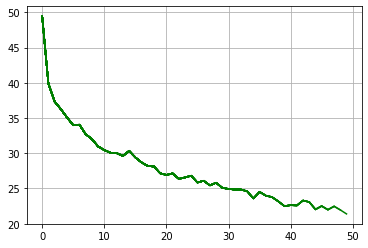

In [26]:
for epoch in range(0,epochs):
    val_loss_epoch = []
    index = np.arange(len(train_data))

    train_data.reset_index()
    np.random.shuffle(index)
    train_data = train_data.loc[index]
    
    current_train_data = train_data.groupby(['video_path']).first().reset_index()

    
    for start, end in zip(
                    range(0, len(current_train_data),batch_size),
                    range(batch_size,len(current_train_data),batch_size)):
    
        start_time = time.time()
        
        current_batch = current_train_data[start:end]
        current_videos = current_batch['video_path'].values
        
        current_feats = np.zeros((batch_size, video_lstm_step,dim_image))
        current_feats_vals = list(map(lambda vid: np.load(vid),current_videos))
        current_feats_vals = np.array(current_feats_vals) 
    
        current_video_masks = np.zeros((batch_size,video_lstm_step))
    
        for ind,feat in enumerate(current_feats_vals):
                    current_feats[ind][:len(current_feats_vals[ind])] = feat
                    current_video_masks[ind][:len(current_feats_vals[ind])] = 1
    
        current_captions = current_batch['Description'].values
        current_captions = list(map(lambda x: '<bos> ' + x, current_captions))
        current_captions = list(map(lambda x: x.replace('.', ''), current_captions))
        current_captions = list(map(lambda x: x.replace(',', ''), current_captions))
        current_captions = list(map(lambda x: x.replace('"', ''), current_captions))
        current_captions = list(map(lambda x: x.replace('\n', ''), current_captions))
        current_captions = list(map(lambda x: x.replace('?', ''), current_captions))
        current_captions = list(map(lambda x: x.replace('!', ''), current_captions))
        current_captions = list(map(lambda x: x.replace('\\', ''), current_captions))
        current_captions = list(map(lambda x: x.replace('/', ''), current_captions))

    
        for idx, each_cap in enumerate(current_captions):
            word = each_cap.lower().split(' ')
            if len(word) < caption_lstm_step:
                current_captions[idx] = current_captions[idx] + ' <eos>'
            else:
                new_word = ''
                for i in range(caption_lstm_step-1):
                    new_word = new_word + word[i] + ' '
                current_captions[idx] = new_word + '<eos>'
    
        current_caption_ind = []
        for cap in current_captions:
            current_word_ind = []
            for word in cap.lower().split(' '):
                if word in word2idx:
                    current_word_ind.append(word2idx[word])
                else:
                    current_word_ind.append(word2idx['<unk>'])
            current_caption_ind.append(current_word_ind)
    
        current_caption_matrix = sequence.pad_sequences(current_caption_ind, padding='post', maxlen=caption_lstm_step)
        current_caption_matrix = np.hstack( [current_caption_matrix, np.zeros( [len(current_caption_matrix), 1] ) ] ).astype(int)
        current_caption_masks = np.zeros( (current_caption_matrix.shape[0], current_caption_matrix.shape[1]) )
        nonzeros = np.array( list(map(lambda x: (x != 0).sum() + 1, current_caption_matrix ) ))
    
        for ind, row in enumerate(current_caption_masks):
            row[:nonzeros[ind]] = 1
    
        probs_val = sess.run(tf_probs, feed_dict={
                    tf_video:current_feats,
                    tf_caption: current_caption_matrix
                    })
    
        _, loss_val = sess.run(
                        [train_op, tf_loss],
                        feed_dict={
                            tf_video: current_feats,
                            tf_video_mask : current_video_masks,
                            tf_caption: current_caption_matrix,
                            tf_caption_mask: current_caption_masks
                            })
        val_loss_epoch.append(loss_val)
    
        print('Batch starting index: ', start, " Epoch: ", epoch, " loss: ", loss_val, ' Elapsed time: ', str((time.time() - start_time)))
        loss_out.write('epoch ' + str(epoch) + ' loss ' + str(loss_val) + '\n')
    
            # draw loss curve every epoch
    val_loss.append(np.mean(val_loss_epoch))
    plt_save_dir = path_prj
    plt_save_img_name = str(epoch) + '.png'
    plt.plot(range(len(val_loss)),val_loss, color='g')
    plt.grid(True)
    plt.savefig(os.path.join(plt_save_dir, plt_save_img_name))
    
    if np.mod(epoch,9) == 0:
        print ("Epoch ", epoch, " is done. Saving the model ...")
        saver.save(sess, os.path.join(path_prj, 'model'), global_step=epoch)
    
loss_out.close()

# Genrating Test data

In [38]:

def get_test_data(text_path,feat_path):
        text_data = pd.read_csv(text_path, sep=',')
        text_data = text_data[text_data['Language'] == 'English']
        text_data['video_path'] = text_data.apply(lambda row: row['VideoID']+'_'+str(int(row['Start']))+'_'+str(int(row['End']))+'.avi.npy', axis=1)
        text_data['video_path'] = text_data['video_path'].map(lambda x: os.path.join(feat_path, x))
        text_data = text_data[text_data['video_path'].map(lambda x: os.path.exists( x ))]
        text_data = text_data[text_data['Description'].map(lambda x: isinstance(x, str))]
    
        unique_filenames = sorted(text_data['video_path'].unique())
        test_data = text_data[text_data['video_path'].map(lambda x: x in unique_filenames)]
        return test_data       
        

# Replicates the Build_Model to derive and define all the tensorflow inputs

In [39]:
def build_generator():
        with tf.device('/cpu:0'):
            word_emb = tf.Variable(tf.random_uniform([n_words, dim_hidden], -0.1, 0.1), name='word_emb')


        lstm1 = tf.nn.rnn_cell.BasicLSTMCell(dim_hidden, state_is_tuple=False)
        lstm2 = tf.nn.rnn_cell.BasicLSTMCell(dim_hidden, state_is_tuple=False)

        encode_W = tf.Variable( tf.random_uniform([dim_image,dim_hidden], -0.1, 0.1), name='encode_W')
        encode_b = tf.Variable( tf.zeros([dim_hidden]), name='encode_b')

        word_emb_W = tf.Variable(tf.random_uniform([dim_hidden,n_words], -0.1,0.1), name='word_emb_W')
        word_emb_b = tf.Variable(tf.zeros([n_words]), name='word_emb_b')
        video = tf.placeholder(tf.float32, [1, video_lstm_step, dim_image])
        video_mask = tf.placeholder(tf.float32, [1, video_lstm_step])

        video_flat = tf.reshape(video, [-1, dim_image])
        image_emb = tf.nn.xw_plus_b(video_flat, encode_W, encode_b)
        image_emb = tf.reshape(image_emb, [1, video_lstm_step, dim_hidden])

        state1 = tf.zeros([1, lstm1.state_size])
        state2 = tf.zeros([1, lstm2.state_size])
        padding = tf.zeros([1, dim_hidden])

        generated_words = []

        probs = []
        embeds = []

        for i in range(0, video_lstm_step):
            if i > 0:
                tf.get_variable_scope().reuse_variables()

            with tf.variable_scope("LSTM1"):
                output1, state1 = lstm1(image_emb[:, i, :], state1)

            with tf.variable_scope("LSTM2"):
                output2, state2 = lstm2(tf.concat([padding, output1],1), state2)

        for i in range(0, caption_lstm_step):
            tf.get_variable_scope().reuse_variables()

            if i == 0:
                with tf.device('/cpu:0'):
                    current_embed = tf.nn.embedding_lookup(word_emb, tf.ones([1], dtype=tf.int64))

            with tf.variable_scope("LSTM1"):
                output1, state1 = lstm1(padding, state1)

            with tf.variable_scope("LSTM2"):
                output2, state2 = lstm2(tf.concat([current_embed, output1],1), state2)

            logit_words = tf.nn.xw_plus_b( output2, word_emb_W, word_emb_b)
            max_prob_index = tf.argmax(logit_words, 1)[0]
            generated_words.append(max_prob_index)
            probs.append(logit_words)

            with tf.device("/cpu:0"):
                current_embed = tf.nn.embedding_lookup(word_emb, max_prob_index)
                current_embed = tf.expand_dims(current_embed, 0)

            embeds.append(current_embed)

        return video, video_mask, generated_words, probs, embeds

In [40]:
test_text_path = text_path
test_feat_path = feat_path
test_data = get_test_data(test_text_path,test_feat_path)
test_videos = test_data['video_path'].unique()

In [23]:
test_data

,VideoID,Start,End,WorkerID,Source,AnnotationTime,Language,Description,video_path
18,mv89psg6zh4,33,46,682611,clean,66,English,A bird in a sink keeps getting under the runni...,C:\Project\features\mv89psg6zh4_33_46.avi.npy
19,mv89psg6zh4,33,46,760882,clean,16,English,A bird is bathing in a sink.,C:\Project\features\mv89psg6zh4_33_46.avi.npy
20,mv89psg6zh4,33,46,878566,clean,76,English,A bird is splashing around under a running fau...,C:\Project\features\mv89psg6zh4_33_46.avi.npy
21,mv89psg6zh4,33,46,707318,clean,14,English,A bird is bathing in a sink.,C:\Project\features\mv89psg6zh4_33_46.avi.npy
22,mv89psg6zh4,33,46,135621,clean,58,English,A bird is standing in a sink drinking water th...,C:\Project\features\mv89psg6zh4_33_46.avi.npy
23,mv89psg6zh4,33,46,257511,clean,57,English,A faucet is running while a bird stands in the...,C:\Project\features\mv89psg6zh4_33_46.avi.npy
24,mv89psg6zh4,33,46,435773,clean,25,English,A bird is playing in a sink with running water.,C:\Project\features\mv89psg6zh4_33_46.avi.npy
25,mv89psg6zh4,33,46,275759,clean,27,English,A bird is playing in tap water.,C:\Project\features\mv89psg6zh4_33_46.avi.npy
26,mv89psg6zh4,33,46,157374,clean,30,English,A bird is bathing in the sink.,C:\Project\features\mv89psg6zh4_33_46.avi.npy
27,mv89psg6zh4,33,46,373663,clean,36,English,A bird is taking a bath.,C:\Project\features\mv89psg6zh4_33_46.avi.npy


In [49]:
idx2word = pd.Series(np.load(path_prj + "\\idx2word.npy",allow_pickle=True).tolist())
n_words = len(idx2word)

In [50]:
tf.reset_default_graph() 
video_tf, video_mask_tf, caption_tf, probs_tf, last_embed_tf = build_generator()

# Loading the Model-45 (Latest saved Model) 

In [58]:

model_path = 'C:\\Project\\model-45'
saver = tf.train.import_meta_graph('C:\\Project\\checkpoint')
sess = tf.InteractiveSession()
saver = tf.train.Saver(reshape=True)
saver.restore(sess,model_path)

OSError: Cannot parse file C:\Project\checkpoint: 1:1 : Message type "tensorflow.MetaGraphDef" has no field named "model_checkpoint_path"..

In [ ]:
f = open(f'{path_prj}/video_captioning_results_Final.txt', 'w',encoding='utf-8')

for idx, video_feat_path in enumerate(test_videos):
            video_feat = np.load(video_feat_path)[None,...]
            if video_feat.shape[1] == frame_step:
                video_mask = np.ones((video_feat.shape[0], video_feat.shape[1]))
            else:
                continue
            gen_word_idx = sess.run(caption_tf, feed_dict={video_tf:video_feat, video_mask_tf:video_mask})
            print (idx)
            gen_words = idx2word[gen_word_idx]
    
            punct = np.argmax(np.array(gen_words) == '<eos>') + 1
            gen_words = gen_words[:punct]
            print (idx)
            gen_sent = ' '.join(gen_words)
            gen_sent = gen_sent.replace('<bos> ', '')
            gen_sent = gen_sent.replace(' <eos>', '')
            print(f'Video path {video_feat_path} : Generated Caption: {gen_sent}')
            print(gen_sent,'\n')
            f.write(video_feat_path + '\n')
            f.write(gen_sent + '\n\n')